# RFECV multi-class prediction

In [1]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None

In [3]:
# Parameters
cluster_col = "SubType"
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None


In [4]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [5]:
adata = anndata.read_h5ad('Markers/cluster_markers.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 9670 × 354 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [7]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [8]:
n_cell = adata.shape[0]
n_test = int(n_cell * test_portion)

In [9]:
# separate test and train
test_cells = adata.obs.sample(n_test, random_state=random_seed).index
test_judge = adata.obs_names.isin(test_cells)
train_judge = ~adata.obs_names.isin(test_cells)

In [10]:
test_df = pd.DataFrame(adata[test_judge, :].X,
                       index=adata.obs_names[test_judge],
                       columns=adata.var_names)
test_label = adata.obs.loc[test_judge, cluster_col]

train_df = pd.DataFrame(adata[train_judge, :].X,
                        index=adata.obs_names[train_judge],
                        columns=adata.var_names)
train_label = adata.obs.loc[train_judge, cluster_col]

## Training

In [11]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [12]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

Fitting estimator with 354 features.
building tree 7 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100building tree 2 of 100
building tree 11 of 100

building tree 6 of 100
building tree 24 of 100
building tree 15 of 100
building tree 13 of 100
building tree 8 of 100
building tree 9 of 100
building tree 19 of 100
building tree 1 of 100
building tree 17 of 100building tree 14 of 100
building tree 12 of 100
building tree 30 of 100
building tree 16 of 100building tree 20 of 100



[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 26 of 100
building tree 25 of 100
building tree 10 of 100

building tree 22 of 100
building tree 29 of 100
building tree 28 of 100
building tree 18 of 100
building tree 23 of 100
building tree 21 of 100
building tree 27 of 100
building tree 31 of 100
building tree 32 of 100
building tree 34 of 100
building tree 35 of 100
building tree 41 of 100building tree 49 of 100
building tree 36 of 100

building tree 37 of 100building tree 44 of 100

building tree 38 of 100building tree 39 of 100

building tree 50 of 100building tree 33 of 100
building tree 47 of 100
building tree 42 of 100building tree 48 of 100
building tree 43 of 100
building tree 51 of 100
building tree 45 of 100building tree 52 of 100



building tree 53 of 100
building tree 58 of 100
building tree 40 of 100
building tree 54 of 100
building tree 57 of 100
building tree 56 of 100
building tree 59 of 100building tree 46 of 100

building tree 60 of 100
building tree 55 of 100


building tree 62 of 100
building tree 63 of 100building tree 61 of 100
building tree 65 of 100

building tree 64 of 100
building tree 69 of 100building tree 67 of 100
building tree 72 of 100

building tree 66 of 100
building tree 74 of 100
building tree 84 of 100building tree 79 of 100
building tree 68 of 100

building tree 73 of 100building tree 83 of 100
building tree 71 of 100
building tree 81 of 100building tree 75 of 100building tree 77 of 100


building tree 70 of 100

building tree 82 of 100
building tree 86 of 100
building tree 80 of 100
building tree 76 of 100
building tree 78 of 100
building tree 88 of 100building tree 87 of 100

building tree 85 of 100
building tree 89 of 100
building tree 90 of 100
building tree 92 of 100
building tree 91 of 100
building tree 97 of 100
building tree 95 of 100
building tree 99 of 100building tree 98 of 100

building tree 93 of 100building tree 96 of 100

building tree 94 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 351 features.
building tree 1 of 100
building tree 5 of 100
building tree 3 of 100
building tree 8 of 100
building tree 7 of 100building tree 10 of 100

building tree 4 of 100
building tree 6 of 100
building tree 9 of 100
building tree 12 of 100
building tree 13 of 100
building tree 11 of 100
building tree 16 of 100
building tree 15 of 100
building tree 18 of 100
building tree 23 of 100
building tree 24 of 100
building tree 17 of 100
building tree 2 of 100
building tree 20 of 100
building tree 27 of 100
building tree 19 of 100
building tree 21 of 100
building tree 22 of 100
building tree 25 of 100building tree 29 of 100

building tree 14 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 28 of 100
building tree 26 of 100
building tree 30 of 100
building tree 31 of 100building tree 37 of 100

building tree 32 of 100building tree 36 of 100

building tree 33 of 100
building tree 35 of 100
building tree 38 of 100
building tree 34 of 100
building tree 40 of 100
building tree 53 of 100building tree 50 of 100

building tree 42 of 100building tree 47 of 100
building tree 39 of 100

building tree 43 of 100
building tree 48 of 100
building tree 51 of 100
building tree 45 of 100
building tree 41 of 100
building tree 49 of 100building tree 52 of 100building tree 55 of 100building tree 46 of 100building tree 44 of 100




building tree 54 of 100
building tree 59 of 100
building tree 56 of 100
building tree 58 of 100building tree 57 of 100

building tree 60 of 100


building tree 61 of 100
building tree 62 of 100
building tree 64 of 100
building tree 63 of 100
building tree 66 of 100
building tree 65 of 100building tree 68 of 100

building tree 67 of 100
building tree 69 of 100
building tree 71 of 100
building tree 70 of 100
building tree 76 of 100
building tree 83 of 100
building tree 72 of 100building tree 80 of 100
building tree 75 of 100
building tree 84 of 100building tree 82 of 100building tree 79 of 100


building tree 78 of 100

building tree 74 of 100building tree 88 of 100

building tree 73 of 100building tree 85 of 100
building tree 89 of 100

building tree 87 of 100building tree 77 of 100

building tree 81 of 100
building tree 86 of 100
building tree 90 of 100
building tree 91 of 100
building tree 93 of 100building tree 94 of 100

building tree 92 of 100
building tree 98 of 100
building tree 95 of 100building tree 96 of 100

building tree 99 of 100
building tree 97 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 348 features.
building tree 4 of 100
building tree 2 of 100
building tree 7 of 100
building tree 10 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 17 of 100
building tree 3 of 100building tree 5 of 100
building tree 14 of 100

building tree 9 of 100
building tree 16 of 100
building tree 1 of 100
building tree 20 of 100
building tree 8 of 100
building tree 21 of 100
building tree 27 of 100
building tree 6 of 100
building tree 13 of 100building tree 18 of 100
building tree 19 of 100

building tree 12 of 100
building tree 30 of 100
building tree 11 of 100
building tree 15 of 100
building tree 24 of 100
building tree 26 of 100
building tree 23 of 100
building tree 22 of 100building tree 29 of 100
building tree 25 of 100

building tree 28 of 100
building tree 31 of 100
building tree 32 of 100building tree 42 of 100

building tree 38 of 100building tree 43 of 100building tree 37 of 100


building tree 34 of 100
building tree 36 of 100
building tree 44 of 100
building tree 47 of 100
building tree 35 of 100building tree 41 of 100

building tree 33 of 100
building tree 39 of 100
building tree 46 of 100
building tree 45 of 10

building tree 60 of 100
building tree 61 of 100
building tree 64 of 100
building tree 62 of 100building tree 66 of 100

building tree 63 of 100
building tree 65 of 100
building tree 73 of 100
building tree 79 of 100
building tree 70 of 100
building tree 68 of 100
building tree 67 of 100building tree 69 of 100

building tree 72 of 100
building tree 71 of 100building tree 74 of 100building tree 76 of 100

building tree 80 of 100

building tree 77 of 100
building tree 75 of 100
building tree 83 of 100
building tree 82 of 100building tree 85 of 100building tree 78 of 100


building tree 86 of 100
building tree 81 of 100building tree 84 of 100

building tree 89 of 100building tree 88 of 100

building tree 87 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 97 of 100building tree 93 of 100building tree 96 of 100


building tree 94 of 100building tree 95 of 100

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


building tree 100 of 100

building tree 99 of 100

building tree 98 of 100


Fitting estimator with 345 features.
building tree 8 of 100
building tree 2 of 100
building tree 7 of 100building tree 10 of 100

building tree 14 of 100
building tree 3 of 100
building tree 1 of 100
building tree 15 of 100
building tree 6 of 100
building tree 12 of 100
building tree 4 of 100
building tree 17 of 100
building tree 13 of 100
building tree 11 of 100
building tree 18 of 100
building tree 16 of 100building tree 19 of 100

building tree 20 of 100
building tree 9 of 100
building tree 5 of 100
building tree 26 of 100
building tree 23 of 100
building tree 24 of 100
building tree 21 of 100
building tree 25 of 100
building tree 28 of 100
building tree 27 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 22 of 100
building tree 30 of 100
building tree 32 of 100
building tree 31 of 100building tree 33 of 100

building tree 42 of 100
building tree 34 of 100
building tree 36 of 100building tree 39 of 100

building tree 37 of 100building tree 44 of 100building tree 49 of 100building tree 40 of 100



building tree 46 of 100
building tree 54 of 100
building tree 38 of 100
building tree 45 of 100
building tree 47 of 100
building tree 41 of 100building tree 50 of 100building tree 35 of 100


building tree 48 of 100
building tree 53 of 100
building tree 43 of 100
building tree 52 of 100
building tree 57 of 100building tree 51 of 100

building tree 59 of 100
building tree 56 of 100
building tree 60 of 100
building tree 55 of 100building tree 58 of 100

building tree 61 of 100


building tree 63 of 100
building tree 62 of 100building tree 68 of 100building tree 64 of 100building tree 65 of 100


building tree 66 of 100

building tree 72 of 100
building tree 67 of 100
building tree 69 of 100
building tree 70 of 100
building tree 74 of 100building tree 73 of 100

building tree 75 of 100building tree 76 of 100

building tree 81 of 100
building tree 71 of 100building tree 77 of 100

building tree 79 of 100building tree 80 of 100

building tree 83 of 100
building tree 78 of 100
building tree 89 of 100
building tree 82 of 100
building tree 84 of 100building tree 86 of 100

building tree 87 of 100building tree 88 of 100

building tree 90 of 100
building tree 85 of 100
building tree 91 of 100
building tree 92 of 100
building tree 95 of 100building tree 98 of 100

building tree 93 of 100
building tree 94 of 100
building tree 97 of 100
building tree 96 of 100
building tree 99 of 100building tree 100 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 342 features.


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 22 of 100building tree 20 of 100

building tree 28 of 100
building tree 12 of 100
building tree 13 of 100
building tree 17 of 100
building tree 3 of 100
building tree 2 of 100
building tree 25 of 100
building tree 9 of 100
building tree 4 of 100
building tree 21 of 100
building tree 27 of 100
building tree 15 of 100
building tree 30 of 100
building tree 26 of 100
building tree 16 of 100
building tree 6 of 100
building tree 8 of 100
building tree 18 of 100
building tree 5 of 100
building tree 19 of 100
building tree 11 of 100
building tree 14 of 100
building tree 7 of 100
building tree 10 of 100
building tree 24 of 100
building tree 1 of 100
building tree 23 of 100
building tree 29 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 36 of 100
building tree 40 of 100
building tree 39 of 100building tree 35 of 100

building tree 34 of 100
building tree 43 of 100building tree 38 of 100
building tree 45 of 100
building tree 41 of 100bui

building tree 48 of 100

building tree 46 of 100
building tree 44 of 100
building tree 53 of 100building tree 50 of 100
building tree 51 of 100
building tree 37 of 100
building tree 54 of 100

building tree 47 of 100building tree 55 of 100

building tree 49 of 100
building tree 57 of 100
building tree 52 of 100
building tree 56 of 100
building tree 60 of 100
building tree 58 of 100
building tree 59 of 100
building tree 61 of 100
building tree 62 of 100
building tree 65 of 100
building tree 71 of 100
building tree 66 of 100building tree 64 of 100

building tree 68 of 100
building tree 70 of 100building tree 63 of 100building tree 80 of 100


building tree 69 of 100
building tree 67 of 100building tree 72 of 100

building tree 75 of 100
building tree 74 of 100building tree 77 of 100
building tree 76 of 100

building tree 73 of 100building tree 84 of 100

building tree 79 of 100
building tree 78 of 100building tree 83 of 100

building tree 81 of 100
building tree 85 of 100
building tree 8

building tree 89 of 100
building tree 87 of 100
building tree 96 of 100
building tree 91 of 100
building tree 95 of 100
building tree 92 of 100
building tree 94 of 100building tree 90 of 100

building tree 93 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 97 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 339 features.
building tree 6 of 100
building tree 3 of 100
building tree 1 of 100
building tree 16 of 100
building tree 18 of 100
building tree 4 of 100
building tree 9 of 100
building tree 25 of 100
building tree 20 of 100
building tree 14 of 100
building tree 12 of 100
building tree 2 of 100
building tree 15 of 100
building tree 10 of 100
building tree 13 of 100
building tree 8 of 100
building tree 19 of 100
building tree 27 of 100
building tree 11 of 100
building tree 7 of 100
building tree 5 of 100
building tree 30 of 100
building tree 21 of 100building tree 23 of 100
building tree 29 of 100
building tree 28 of 100
building tree 26 of 100

building tree 17 of 100
building tree 22 of 100

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 24 of 100

building tree 34 of 100
building tree 35 of 100
building tree 31 of 100building tree 38 of 100building tree 43 of 100


building tree 39 of 100building tree 33 of 100

building tree 46 of 100
building tree 36 of 100
building tree 53 of 100building tree 41 of 100

building tree 44 of 100building tree 56 of 100building tree 55 of 100building tree 42 of 100
building tree 49 of 100
building tree 32 of 100

building tree 52 of 100building tree 37 of 100


building tree 50 of 100building tree 51 of 100


building tree 47 of 100building tree 48 of 100

building tree 45 of 100building tree 58 of 100

building tree 57 of 100
building tree 40 of 100building tree 54 of 100

building tree 60 of 100
building tree 59 of 100


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100building tree 71 of 100

building tree 68 of 100building tree 69 of 100

building tree 76 of 100
building tree 79 of 100building tree 64 of 100
building tree 78 of 100
building tree 70 of 100building tree 87 of 100
building tree 67 of 100building tree 72 of 100
building tree 74 of 100
building tree 81 of 100
building tree 65 of 100

building tree 66 of 100


building tree 77 of 100building tree 80 of 100
building tree 73 of 100

building tree 75 of 100
building tree 88 of 100
building tree 82 of 100
building tree 84 of 100building tree 85 of 100

building tree 83 of 100
building tree 86 of 100
building tree 89 of 100
building tree 90 of 100
building tree 92 of 100building tree 93 of 100

building tree 91 of 100
building tree 99 of 100building tree 97 of 100
building tree 94 of 100building tree 98 of 100
building tree 100 of 100


building tree 96 of 100
building tree 95 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 336 features.
building tree 3 of 100
building tree 4 of 100
building tree 8 of 100
building tree 16 of 100
building tree 1 of 100
building tree 5 of 100
building tree 14 of 100
building tree 9 of 100
building tree 2 of 100
building tree 6 of 100
building tree 10 of 100
building tree 7 of 100
building tree 25 of 100
building tree 12 of 100
building tree 24 of 100
building tree 11 of 100
building tree 23 of 100
building tree 17 of 100
building tree 18 of 100
building tree 15 of 100
building tree 19 of 100
building tree 30 of 100
building tree 29 of 100
building tree 27 of 100
building tree 21 of 100
building tree 28 of 100
building tree 26 of 100
building tree 20 of 100
building tree 22 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 13 of 100
building tree 34 of 100
building tree 32 of 100
building tree 31 of 100
building tree 35 of 100building tree 38 of 100

building tree 41 of 100
building tree 36 of 100
building tree 39 of 100building tree 33 of 100
building tree 40 of 100building tree 42 of 100


building tree 37 of 100
building tree 45 of 100
building tree 46 of 100
building tree 50 of 100
building tree 44 of 100building tree 49 of 100

building tree 58 of 100building tree 48 of 100building tree 43 of 100building tree 47 of 100
building tree 55 of 100



building tree 53 of 100building tree 54 of 100building tree 52 of 100

building tree 51 of 100building tree 56 of 100


building tree 57 of 100
building tree 60 of 100
building tree 59 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 66 of 100
building tree 65 of 100building tree 69 of 100building tree 64 of 100




building tree 76 of 100building tree 75 of 100

building tree 71 of 100building tree 68 of 100
building tree 67 of 100

building tree 70 of 100
building tree 73 of 100
building tree 78 of 100
building tree 74 of 100
building tree 72 of 100
building tree 85 of 100building tree 77 of 100

building tree 84 of 100
building tree 83 of 100building tree 80 of 100building tree 79 of 100building tree 87 of 100

building tree 86 of 100
building tree 82 of 100


building tree 81 of 100
building tree 88 of 100
building tree 92 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 93 of 100
building tree 98 of 100
building tree 95 of 100
building tree 94 of 100
building tree 99 of 100
building tree 100 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 333 features.
building tree 3 of 100building tree 7 of 100
building tree 5 of 100

building tree 2 of 100
building tree 4 of 100
building tree 10 of 100
building tree 12 of 100
building tree 1 of 100
building tree 6 of 100
building tree 13 of 100
building tree 9 of 100
building tree 25 of 100
building tree 15 of 100
building tree 28 of 100
building tree 18 of 100
building tree 14 of 100building tree 16 of 100
building tree 11 of 100
building tree 8 of 100

building tree 23 of 100
building tree 17 of 100
building tree 20 of 100
building tree 19 of 100
building tree 21 of 100
building tree 26 of 100
building tree 22 of 100
building tree 29 of 100
building tree 24 of 100
building tree 27 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 30 of 100
building tree 31 of 100
building tree 34 of 100
building tree 42 of 100building tree 38 of 100
building tree 41 of 100
building tree 36 of 100building tree 37 of 100building tree 39 of 100



building tree 32 of 100building tree 35 of 100

building tree 40 of 100
building tree 43 of 100
building tree 46 of 100
building tree 33 of 100building tree 49 of 100

building tree 45 of 100
building tree 52 of 100building tree 51 of 100
building tree 44 of 100
building tree 55 of 100

building tree 53 of 100building tree 47 of 100

building tree 56 of 100
building tree 54 of 100
building tree 50 of 100
building tree 59 of 100building tree 48 of 100

building tree 57 of 100
building tree 58 of 100
building tree 60 of 100


building tree 66 of 100building tree 61 of 100building tree 63 of 100


building tree 67 of 100
building tree 65 of 100building tree 62 of 100building tree 68 of 100
building tree 64 of 100


building tree 74 of 100
building tree 69 of 100
building tree 73 of 100
building tree 72 of 100building tree 75 of 100

building tree 71 of 100
building tree 76 of 100
building tree 79 of 100
building tree 78 of 100
building tree 81 of 100
building tree 80 of 100
building tree 77 of 100building tree 84 of 100building tree 83 of 100building tree 70 of 100



building tree 85 of 100
building tree 82 of 100
building tree 88 of 100
building tree 89 of 100building tree 86 of 100

building tree 87 of 100
building tree 90 of 100building tree 92 of 100

building tree 93 of 100
building tree 95 of 100
building tree 91 of 100
building tree 94 of 100
building tree 98 of 100
building tree 96 of 100
building tree 97 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 330 features.
building tree 19 of 100
building tree 5 of 100
building tree 9 of 100building tree 23 of 100

building tree 1 of 100building tree 3 of 100building tree 10 of 100


building tree 7 of 100building tree 2 of 100building tree 17 of 100

building tree 15 of 100

building tree 4 of 100building tree 6 of 100
building tree 20 of 100
building tree 24 of 100
building tree 13 of 100
building tree 18 of 100

building tree 25 of 100building tree 8 of 100
building tree 22 of 100
building tree 21 of 100

building tree 27 of 100
building tree 11 of 100
building tree 30 of 100
building tree 26 of 100building tree 14 of 100building tree 29 of 100


building tree 16 of 100
building tree 12 of 100
building tree 28 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 39 of 100
building tree 37 of 100building tree 33 of 100building tree 38 of 100

building tree 41 of 100
building tree 45 of 100building tree 32 of 100


building tree 56 of 100
building tree 46 of 100building tree 43 of 100building tree 34 of 100
building tree 36 of 100
building tree 55 of 100building tree 44 of 100

building tree 42 of 100

building tree 35 of 100building tree 57 of 100
building tree 50 of 100

building tree 40 of 100

building tree 48 of 100
building tree 51 of 100
building tree 47 of 100building tree 58 of 100
building tree 49 of 100

building tree 54 of 100building tree 52 of 100
building tree 53 of 100

building tree 60 of 100
building tree 59 of 100
building tree 62 of 100
building tree 63 of 100
building tree 61 of 100
building tree 65 of 100
building tree 66 of 100building tree 72 of 100



building tree 69 of 100building tree 74 of 100building tree 64 of 100


building tree 75 of 100
building tree 70 of 100
building tree 80 of 100building tree 67 of 100
building tree 76 of 100building tree 79 of 100


building tree 71 of 100building tree 86 of 100

building tree 82 of 100building tree 73 of 100

building tree 78 of 100
building tree 83 of 100
building tree 77 of 100building tree 87 of 100
building tree 88 of 100
building tree 68 of 100

building tree 81 of 100
building tree 85 of 100
building tree 84 of 100
building tree 89 of 100
building tree 91 of 100
building tree 90 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 97 of 100
building tree 99 of 100
building tree 100 of 100
building tree 96 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 327 features.
building tree 8 of 100
building tree 1 of 100
building tree 11 of 100building tree 5 of 100

building tree 2 of 100
building tree 4 of 100
building tree 6 of 100
building tree 18 of 100
building tree 7 of 100
building tree 15 of 100
building tree 3 of 100
building tree 16 of 100
building tree 14 of 100
building tree 19 of 100
building tree 12 of 100
building tree 17 of 100building tree 13 of 100

building tree 26 of 100
building tree 10 of 100
building tree 21 of 100
building tree 22 of 100
building tree 24 of 100
building tree 27 of 100
building tree 23 of 100
building tree 9 of 100
building tree 25 of 100
building tree 29 of 100
building tree 30 of 100
building tree 28 of 100
building tree 20 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100building tree 31 of 100

building tree 34 of 100
building tree 39 of 100
building tree 33 of 100
building tree 36 of 100
building tree 41 of 100building tree 40 of 100
building tree 42 of 100building tree 45 of 100


building tree 37 of 100building tree 49 of 100

building tree 44 of 100building tree 35 of 100
building tree 50 of 100

building tree 43 of 100
building tree 46 of 100
building tree 58 of 100
building tree 48 of 100
building tree 54 of 100building tree 57 of 100
building tree 47 of 100

building tree 38 of 100
building tree 56 of 100building tree 53 of 100

building tree 51 of 100building tree 55 of 100
building tree 52 of 100

building tree 60 of 100
building tree 59 of 100
building tree 62 of 100
building tree 63 of 100building tree 61 of 100

building tree 67 of 100building tree 64 of 100

building tree 71 of 100
building tree 65 of 100
building tree 68 of 100


building tree 75 of 100building tree 73 of 100
building tree 77 of 100

building tree 80 of 100
building tree 70 of 100
building tree 74 of 100building tree 66 of 100
building tree 78 of 100

building tree 76 of 100
building tree 79 of 100
building tree 72 of 100
building tree 69 of 100
building tree 81 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 88 of 100
building tree 82 of 100
building tree 86 of 100
building tree 87 of 100
building tree 89 of 100
building tree 90 of 100
building tree 93 of 100
building tree 91 of 100
building tree 94 of 100building tree 92 of 100
building tree 97 of 100building tree 96 of 100


building tree 99 of 100
building tree 95 of 100building tree 100 of 100
building tree 98 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 324 features.
building tree 8 of 100
building tree 10 of 100
building tree 9 of 100
building tree 1 of 100
building tree 3 of 100
building tree 2 of 100building tree 12 of 100
building tree 6 of 100

building tree 4 of 100
building tree 17 of 100
building tree 16 of 100
building tree 19 of 100
building tree 21 of 100
building tree 29 of 100
building tree 11 of 100
building tree 14 of 100
building tree 18 of 100
building tree 5 of 100
building tree 22 of 100
building tree 13 of 100
building tree 15 of 100
building tree 28 of 100
building tree 24 of 100
building tree 27 of 100
building tree 30 of 100
building tree 23 of 100
building tree 7 of 100
building tree 20 of 100
building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100
building tree 36 of 100building tree 41 of 100building tree 31 of 100
building tree 34 of 100
building tree 33 of 100


building tree 38 of 100
building tree 55 of 100building tree 37 of 100building tree 44 of 100


building tree 40 of 100building tree 45 of 100

building tree 59 of 100building tree 50 of 100building tree 35 of 100

building tree 48 of 100

building tree 46 of 100building tree 53 of 100
building tree 39 of 100
building tree 54 of 100
building tree 49 of 100
building tree 51 of 100

building tree 42 of 100
building tree 43 of 100building tree 47 of 100

building tree 60 of 100
building tree 52 of 100
building tree 57 of 100
building tree 56 of 100
building tree 58 of 100
building tree 61 of 100
building tree 64 of 100
building tree 62 of 100
building tree 70 of 100building tree 74 of 100

building tree 69 of 100building tree 76 of 100building tree 67 of 100


building tree 68 of 100building tree 71 of 100building tree 66 of 100


building tree 75

building tree 77 of 100building tree 83 of 100

building tree 82 of 100
building tree 78 of 100
building tree 85 of 100
building tree 81 of 100building tree 79 of 100

building tree 84 of 100
building tree 88 of 100building tree 86 of 100

building tree 87 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 95 of 100
building tree 92 of 100
building tree 97 of 100
building tree 93 of 100building tree 94 of 100

building tree 98 of 100
building tree 96 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 321 features.
building tree 6 of 100
building tree 5 of 100
building tree 7 of 100building tree 2 of 100

building tree 4 of 100building tree 1 of 100
building tree 9 of 100

building tree 3 of 100
building tree 22 of 100
building tree 17 of 100
building tree 8 of 100building tree 15 of 100

building tree 11 of 100
building tree 20 of 100
building tree 10 of 100
building tree 14 of 100
building tree 24 of 100
building tree 18 of 100
building tree 13 of 100
building tree 21 of 100
building tree 28 of 100
building tree 19 of 100
building tree 27 of 100
building tree 23 of 100building tree 16 of 100
building tree 30 of 100

building tree 26 of 100
building tree 12 of 100
building tree 25 of 100building tree 29 of 100



[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 32 of 100
building tree 35 of 100
building tree 33 of 100
building tree 34 of 100
building tree 36 of 100building tree 44 of 100

building tree 38 of 100building tree 37 of 100building tree 41 of 100


building tree 51 of 100
building tree 43 of 100
building tree 49 of 100building tree 50 of 100building tree 40 of 100

building tree 55 of 100
building tree 52 of 100

building tree 42 of 100building tree 48 of 100
building tree 39 of 100
building tree 45 of 100
building tree 46 of 100

building tree 56 of 100
building tree 53 of 100
building tree 54 of 100
building tree 57 of 100
building tree 58 of 100
building tree 47 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 66 of 100
building tree 62 of 100
building tree 64 of 100


building tree 69 of 100
building tree 63 of 100
building tree 68 of 100building tree 71 of 100

building tree 67 of 100
building tree 65 of 100
building tree 76 of 100building tree 73 of 100building tree 72 of 100


building tree 86 of 100
building tree 70 of 100building tree 77 of 100

building tree 78 of 100building tree 74 of 100
building tree 75 of 100building tree 82 of 100building tree 79 of 100



building tree 84 of 100building tree 81 of 100

building tree 83 of 100
building tree 80 of 100
building tree 88 of 100building tree 85 of 100

building tree 89 of 100
building tree 90 of 100building tree 87 of 100building tree 91 of 100


building tree 93 of 100building tree 94 of 100

building tree 97 of 100
building tree 92 of 100
building tree 98 of 100
building tree 99 of 100building tree 95 of 100

building tree 100 of 100
building tree 96 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 318 features.
building tree 2 of 100building tree 4 of 100building tree 7 of 100


building tree 9 of 100
building tree 5 of 100
building tree 3 of 100
building tree 13 of 100
building tree 6 of 100
building tree 12 of 100
building tree 16 of 100
building tree 15 of 100
building tree 1 of 100
building tree 11 of 100
building tree 8 of 100
building tree 18 of 100
building tree 25 of 100
building tree 21 of 100
building tree 20 of 100building tree 24 of 100

building tree 14 of 100
building tree 22 of 100
building tree 27 of 100
building tree 23 of 100
building tree 17 of 100
building tree 10 of 100
building tree 30 of 100
building tree 28 of 100
building tree 19 of 100
building tree 26 of 100
building tree 29 of 100

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.



building tree 31 of 100
building tree 35 of 100
building tree 46 of 100
building tree 32 of 100
building tree 36 of 100
building tree 41 of 100
building tree 40 of 100
building tree 50 of 100
building tree 34 of 100building tree 37 of 100
building tree 33 of 100
building tree 42 of 100

building tree 45 of 100
building tree 43 of 100building tree 52 of 100
building tree 38 of 100

building tree 55 of 100building tree 51 of 100
building tree 49 of 100

building tree 44 of 100
building tree 39 of 100
building tree 48 of 100building tree 53 of 100building tree 59 of 100
building tree 47 of 100
building tree 57 of 100

building tree 54 of 100

building tree 56 of 100
building tree 58 of 100
building tree 60 of 100
building tree 62 of 100


building tree 63 of 100
building tree 61 of 100
building tree 65 of 100building tree 64 of 100

building tree 71 of 100
building tree 67 of 100
building tree 66 of 100building tree 69 of 100

building tree 74 of 100building tree 72 of 100building tree 68 of 100
building tree 79 of 100


building tree 75 of 100
building tree 83 of 100
building tree 70 of 100
building tree 77 of 100
building tree 80 of 100building tree 82 of 100

building tree 78 of 100
building tree 76 of 100
building tree 81 of 100building tree 73 of 100

building tree 85 of 100
building tree 84 of 100building tree 86 of 100

building tree 88 of 100
building tree 87 of 100
building tree 90 of 100
building tree 89 of 100
building tree 92 of 100
building tree 91 of 100
building tree 95 of 100
building tree 94 of 100
building tree 98 of 100
building tree 96 of 100
building tree 93 of 100
building tree 97 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 315 features.
building tree 3 of 100building tree 1 of 100
building tree 4 of 100

building tree 8 of 100
building tree 9 of 100
building tree 15 of 100
building tree 10 of 100
building tree 11 of 100
building tree 17 of 100building tree 5 of 100

building tree 7 of 100
building tree 14 of 100
building tree 27 of 100
building tree 6 of 100building tree 22 of 100
building tree 24 of 100

building tree 12 of 100
building tree 16 of 100
building tree 25 of 100
building tree 13 of 100
building tree 23 of 100
building tree 18 of 100
building tree 19 of 100
building tree 21 of 100building tree 2 of 100

building tree 26 of 100
building tree 28 of 100building tree 20 of 100

building tree 30 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 29 of 100
building tree 32 of 100
building tree 33 of 100building tree 31 of 100

building tree 35 of 100
building tree 34 of 100building tree 39 of 100building tree 36 of 100


building tree 37 of 100
building tree 40 of 100building tree 44 of 100

building tree 43 of 100building tree 48 of 100

building tree 42 of 100building tree 51 of 100building tree 47 of 100


building tree 53 of 100building tree 54 of 100

building tree 41 of 100
building tree 38 of 100
building tree 45 of 100building tree 46 of 100building tree 55 of 100


building tree 52 of 100
building tree 50 of 100building tree 49 of 100

building tree 57 of 100
building tree 58 of 100building tree 60 of 100

building tree 56 of 100
building tree 59 of 100
building tree 61 of 100


building tree 69 of 100
building tree 63 of 100
building tree 65 of 100
building tree 64 of 100
building tree 66 of 100building tree 68 of 100building tree 71 of 100building tree 81 of 100building tree 67 of 100




building tree 70 of 100
building tree 82 of 100building tree 76 of 100building tree 62 of 100


building tree 78 of 100
building tree 75 of 100
building tree 74 of 100building tree 72 of 100

building tree 73 of 100
building tree 80 of 100
building tree 77 of 100building tree 79 of 100

building tree 83 of 100
building tree 84 of 100
building tree 85 of 100building tree 86 of 100

building tree 87 of 100
building tree 89 of 100
building tree 88 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 99 of 100
building tree 96 of 100
building tree 95 of 100building tree 94 of 100
building tree 93 of 100

building tree 100 of 100
building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 312 features.
building tree 4 of 100building tree 2 of 100

building tree 5 of 100
building tree 1 of 100
building tree 6 of 100
building tree 14 of 100
building tree 12 of 100
building tree 3 of 100
building tree 22 of 100
building tree 21 of 100
building tree 10 of 100
building tree 13 of 100
building tree 17 of 100
building tree 11 of 100
building tree 9 of 100
building tree 8 of 100
building tree 24 of 100
building tree 16 of 100
building tree 25 of 100
building tree 23 of 100
building tree 20 of 100
building tree 15 of 100
building tree 7 of 100
building tree 19 of 100
building tree 29 of 100
building tree 28 of 100
building tree 18 of 100
building tree 27 of 100
building tree 30 of 100building tree 26 of 100



[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 37 of 100
building tree 33 of 100building tree 32 of 100

building tree 39 of 100
building tree 44 of 100building tree 40 of 100

building tree 35 of 100
building tree 46 of 100building tree 49 of 100

building tree 36 of 100
building tree 41 of 100
building tree 55 of 100
building tree 50 of 100
building tree 42 of 100building tree 43 of 100building tree 53 of 100
building tree 51 of 100
building tree 34 of 100
building tree 47 of 100


building tree 58 of 100
building tree 45 of 100building tree 54 of 100

building tree 48 of 100
building tree 52 of 100
building tree 56 of 100
building tree 38 of 100
building tree 57 of 100
building tree 60 of 100
building tree 59 of 100
building tree 64 of 100
building tree 63 of 100
building tree 62 of 100
building tree 65 of 100
building tree 61 of 100
building tree 70 of 100building tree 74 of 100building tree 69 of 100


building tree 68 of 100building tree 66 of 100



building tree 67 of 100building tree 72 of 100building tree 73 of 100
building tree 76 of 100


building tree 75 of 100building tree 71 of 100

building tree 78 of 100building tree 79 of 100building tree 77 of 100

building tree 82 of 100

building tree 81 of 100
building tree 84 of 100building tree 80 of 100

building tree 83 of 100
building tree 85 of 100
building tree 86 of 100
building tree 89 of 100
building tree 88 of 100
building tree 87 of 100
building tree 95 of 100
building tree 90 of 100
building tree 91 of 100
building tree 93 of 100
building tree 96 of 100
building tree 94 of 100
building tree 97 of 100
building tree 92 of 100building tree 98 of 100

building tree 100 of 100building tree 99 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 309 features.
building tree 5 of 100
building tree 3 of 100building tree 7 of 100

building tree 11 of 100
building tree 2 of 100
building tree 10 of 100
building tree 4 of 100
building tree 14 of 100
building tree 1 of 100
building tree 17 of 100
building tree 12 of 100
building tree 6 of 100
building tree 8 of 100
building tree 24 of 100
building tree 20 of 100
building tree 19 of 100
building tree 9 of 100
building tree 25 of 100
building tree 30 of 100
building tree 13 of 100
building tree 21 of 100
building tree 16 of 100
building tree 22 of 100
building tree 27 of 100
building tree 26 of 100
building tree 15 of 100
building tree 28 of 100
building tree 18 of 100
building tree 29 of 100
building tree 23 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100
building tree 31 of 100
building tree 34 of 100
building tree 37 of 100
building tree 36 of 100building tree 39 of 100building tree 40 of 100
building tree 35 of 100


building tree 41 of 100building tree 43 of 100

building tree 47 of 100building tree 46 of 100building tree 51 of 100building tree 49 of 100



building tree 33 of 100building tree 44 of 100building tree 48 of 100
building tree 45 of 100


building tree 42 of 100
building tree 50 of 100building tree 54 of 100
building tree 53 of 100
building tree 38 of 100

building tree 56 of 100
building tree 52 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 55 of 100
building tree 60 of 100
building tree 64 of 100
building tree 61 of 100
building tree 63 of 100
building tree 62 of 100
building tree 68 of 100
building tree 72 of 100
building tree 65 of 100
building tree 66 of 100building tree 70 of 100
building tree 67 of 100building tree 69 of 100

building tree 71 

building tree 73 of 100
building tree 84 of 100building tree 74 of 100
building tree 85 of 100

building tree 80 of 100
building tree 75 of 100
building tree 82 of 100
building tree 79 of 100
building tree 81 of 100
building tree 76 of 100
building tree 89 of 100
building tree 83 of 100
building tree 86 of 100
building tree 78 of 100building tree 88 of 100

building tree 90 of 100
building tree 87 of 100
building tree 93 of 100
building tree 91 of 100
building tree 94 of 100
building tree 97 of 100
building tree 92 of 100
building tree 98 of 100building tree 99 of 100

building tree 100 of 100
building tree 95 of 100building tree 96 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 306 features.
building tree 2 of 100
building tree 5 of 100
building tree 3 of 100
building tree 18 of 100
building tree 1 of 100
building tree 24 of 100building tree 9 of 100building tree 10 of 100
building tree 11 of 100

building tree 14 of 100
building tree 4 of 100
building tree 8 of 100

building tree 6 of 100
building tree 15 of 100
building tree 7 of 100
building tree 17 of 100
building tree 12 of 100
building tree 16 of 100
building tree 19 of 100
building tree 13 of 100
building tree 28 of 100
building tree 23 of 100
building tree 20 of 100
building tree 22 of 100
building tree 29 of 100
building tree 21 of 100
building tree 30 of 100
building tree 25 of 100
building tree 27 of 100
building tree 26 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100building tree 39 of 100

building tree 32 of 100
building tree 35 of 100
building tree 40 of 100
building tree 37 of 100building tree 44 of 100

building tree 42 of 100building tree 38 of 100building tree 43 of 100building tree 33 of 100

building tree 47 of 100

building tree 48 of 100
building tree 51 of 100
building tree 34 of 100

building tree 41 of 100
building tree 49 of 100
building tree 53 of 100
building tree 52 of 100
building tree 45 of 100
building tree 36 of 100building tree 57 of 100

building tree 46 of 100
building tree 58 of 100building tree 56 of 100
building tree 54 of 100
building tree 59 of 100

building tree 55 of 100building tree 50 of 100

building tree 60 of 100
building tree 66 of 100
building tree 61 of 100building tree 64 of 100building tree 63 of 100


building tree 62 of 100
building tree 69 of 100building tree 70 of 100

building tree 71 of 100
building tree 72 of 100building tree 68 of 100

building tree 65 of 100
building tree 67

building tree 81 of 100building tree 76 of 100

building tree 77 of 100
building tree 79 of 100
building tree 74 of 100building tree 83 of 100building tree 80 of 100


building tree 89 of 100building tree 86 of 100

building tree 84 of 100building tree 85 of 100building tree 88 of 100


building tree 87 of 100
building tree 90 of 100
building tree 82 of 100
building tree 91 of 100
building tree 92 of 100
building tree 94 of 100
building tree 93 of 100building tree 96 of 100

building tree 98 of 100
building tree 97 of 100
building tree 95 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 303 features.
building tree 10 of 100
building tree 7 of 100
building tree 8 of 100
building tree 2 of 100
building tree 6 of 100
building tree 9 of 100
building tree 1 of 100
building tree 11 of 100
building tree 15 of 100
building tree 3 of 100
building tree 26 of 100
building tree 21 of 100
building tree 5 of 100
building tree 14 of 100
building tree 13 of 100
building tree 22 of 100
building tree 4 of 100
building tree 12 of 100
building tree 17 of 100
building tree 24 of 100
building tree 20 of 100
building tree 18 of 100
building tree 23 of 100
building tree 29 of 100
building tree 19 of 100
building tree 30 of 100
building tree 16 of 100
building tree 25 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100building tree 31 of 100
building tree 36 of 100

building tree 35 of 100building tree 33 of 100

building tree 45 of 100building tree 34 of 100

building tree 37 of 100
building tree 39 of 100
building tree 42 of 100building tree 38 of 100

building tree 40 of 100
building tree 49 of 100
building tree 44 of 100building tree 48 of 100

building tree 46 of 100
building tree 47 of 100
building tree 55 of 100building tree 51 of 100building tree 50 of 100


building tree 53 of 100building tree 52 of 100building tree 56 of 100
building tree 54 of 100building tree 43 of 100

building tree 41 of 100


building tree 59 of 100
building tree 57 of 100
building tree 58 of 100
building tree 60 of 100
building tree 61 of 100
building tree 63 of 100


building tree 64 of 100building tree 69 of 100

building tree 68 of 100building tree 62 of 100

building tree 74 of 100
building tree 72 of 100
building tree 65 of 100
building tree 71 of 100
building tree 67 of 100
building tree 70 of 100
building tree 66 of 100
building tree 73 of 100
building tree 75 of 100
building tree 77 of 100
building tree 88 of 100
building tree 84 of 100building tree 83 of 100building tree 78 of 100
building tree 85 of 100

building tree 76 of 100

building tree 87 of 100
building tree 79 of 100building tree 82 of 100building tree 80 of 100


building tree 86 of 100
building tree 81 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 94 of 100
building tree 93 of 100building tree 99 of 100

building tree 97 of 100
building tree 92 of 100
building tree 96 of 100
building tree 95 of 100
building tree 100 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 300 features.
building tree 4 of 100
building tree 6 of 100
building tree 7 of 100
building tree 13 of 100
building tree 2 of 100
building tree 1 of 100
building tree 11 of 100
building tree 21 of 100
building tree 10 of 100
building tree 3 of 100
building tree 9 of 100
building tree 23 of 100
building tree 8 of 100
building tree 15 of 100
building tree 12 of 100
building tree 5 of 100
building tree 24 of 100
building tree 14 of 100
building tree 25 of 100
building tree 26 of 100
building tree 20 of 100
building tree 18 of 100
building tree 27 of 100
building tree 30 of 100
building tree 22 of 100
building tree 17 of 100
building tree 28 of 100
building tree 29 of 100
building tree 16 of 100
building tree 19 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100building tree 33 of 100
building tree 35 of 100
building tree 37 of 100

building tree 31 of 100
building tree 38 of 100
building tree 34 of 100building tree 46 of 100

building tree 36 of 100building tree 42 of 100
building tree 47 of 100
building tree 40 of 100

building tree 43 of 100
building tree 53 of 100building tree 55 of 100
building tree 39 of 100
building tree 41 of 100

building tree 44 of 100
building tree 51 of 100
building tree 45 of 100
building tree 54 of 100
building tree 48 of 100
building tree 57 of 100
building tree 58 of 100
building tree 52 of 100building tree 49 of 100building tree 50 of 100


building tree 56 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 68 of 100building tree 67 of 100building tree 69 of 100
building tree 70 of 100




building tree 79 of 100building tree 74 of 100

building tree 72 of 100building tree 77 of 100

building tree 71 of 100
building tree 73 of 100building tree 75 of 100

building tree 78 of 100
building tree 81 of 100
building tree 80 of 100
building tree 85 of 100
building tree 76 of 100
building tree 83 of 100
building tree 86 of 100building tree 84 of 100

building tree 88 of 100
building tree 87 of 100
building tree 82 of 100
building tree 89 of 100
building tree 90 of 100
building tree 94 of 100
building tree 91 of 100
building tree 93 of 100
building tree 92 of 100
building tree 96 of 100
building tree 98 of 100
building tree 95 of 100
building tree 97 of 100building tree 99 of 100

building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 297 features.
building tree 7 of 100
building tree 2 of 100
building tree 1 of 100
building tree 6 of 100
building tree 5 of 100
building tree 11 of 100
building tree 10 of 100
building tree 16 of 100
building tree 4 of 100
building tree 3 of 100
building tree 12 of 100
building tree 19 of 100
building tree 9 of 100
building tree 23 of 100
building tree 8 of 100
building tree 15 of 100
building tree 22 of 100
building tree 18 of 100
building tree 14 of 100
building tree 21 of 100
building tree 26 of 100
building tree 28 of 100
building tree 17 of 100
building tree 24 of 100
building tree 27 of 100
building tree 20 of 100
building tree 25 of 100
building tree 29 of 100
building tree 30 of 100
building tree 13 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 34 of 100
building tree 32 of 100building tree 35 of 100
building tree 33 of 100
building tree 37 of 100
building tree 36 of 100

building tree 48 of 100building tree 44 of 100

building tree 46 of 100building tree 47 of 100

building tree 40 of 100building tree 43 of 100

building tree 49 of 100
building tree 45 of 100
building tree 55 of 100
building tree 39 of 100building tree 38 of 100
building tree 41 of 100
building tree 54 of 100

building tree 50 of 100building tree 42 of 100

building tree 51 of 100
building tree 52 of 100
building tree 57 of 100
building tree 58 of 100
building tree 53 of 100building tree 56 of 100

building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 65 of 100
building tree 63 of 100
building tree 64 of 100


building tree 66 of 100building tree 76 of 100

building tree 68 of 100
building tree 69 of 100
building tree 81 of 100building tree 74 of 100building tree 67 of 100
building tree 75 of 100

building tree 70 of 100
building tree 77 of 100building tree 71 of 100


building tree 72 of 100building tree 82 of 100

building tree 78 of 100
building tree 83 of 100
building tree 87 of 100
building tree 80 of 100building tree 86 of 100
building tree 85 of 100

building tree 79 of 100building tree 73 of 100

building tree 84 of 100
building tree 89 of 100
building tree 88 of 100
building tree 90 of 100
building tree 92 of 100
building tree 93 of 100building tree 91 of 100

building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 99 of 100
building tree 100 of 100building tree 98 of 100

building tree 97 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 294 features.
building tree 1 of 100
building tree 6 of 100
building tree 3 of 100
building tree 14 of 100
building tree 7 of 100
building tree 10 of 100
building tree 5 of 100
building tree 9 of 100
building tree 8 of 100
building tree 19 of 100
building tree 13 of 100
building tree 16 of 100
building tree 27 of 100
building tree 4 of 100
building tree 24 of 100
building tree 25 of 100
building tree 2 of 100
building tree 21 of 100
building tree 20 of 100
building tree 18 of 100
building tree 26 of 100
building tree 22 of 100
building tree 12 of 100
building tree 23 of 100
building tree 29 of 100building tree 11 of 100

building tree 17 of 100
building tree 15 of 100
building tree 28 of 100
building tree 30 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 33 of 100
building tree 35 of 100building tree 34 of 100

building tree 32 of 100building tree 37 of 100

building tree 31 of 100
building tree 44 of 100building tree 39 of 100
building tree 45 of 100building tree 40 of 100
building tree 36 of 100
building tree 49 of 100
building tree 48 of 100
building tree 41 of 100


building tree 42 of 100building tree 38 of 100

building tree 46 of 100
building tree 53 of 100
building tree 50 of 100
building tree 57 of 100
building tree 47 of 100
building tree 43 of 100
building tree 51 of 100
building tree 58 of 100
building tree 56 of 100
building tree 52 of 100
building tree 60 of 100
building tree 59 of 100building tree 55 of 100

building tree 54 of 100
building tree 64 of 100
building tree 61 of 100
building tree 69 of 100
building tree 73 of 100
building tree 67 of 100
building tree 70 of 100building tree 71 of 100building tree 65 of 100building tree 66 of 100



building tree 68 of 100
building tree 63 of 100building tree 74 

building tree 82 of 100building tree 81 of 100

building tree 78 of 100
building tree 86 of 100
building tree 83 of 100
building tree 80 of 100
building tree 85 of 100
building tree 90 of 100
building tree 84 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 93 of 100
building tree 94 of 100building tree 92 of 100
building tree 96 of 100
building tree 99 of 100

building tree 91 of 100building tree 95 of 100

building tree 100 of 100
building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 291 features.
building tree 1 of 100
building tree 9 of 100building tree 11 of 100

building tree 6 of 100
building tree 8 of 100
building tree 13 of 100
building tree 4 of 100
building tree 3 of 100
building tree 2 of 100
building tree 7 of 100
building tree 10 of 100
building tree 16 of 100
building tree 17 of 100
building tree 5 of 100
building tree 15 of 100
building tree 12 of 100
building tree 25 of 100
building tree 26 of 100
building tree 20 of 100
building tree 14 of 100
building tree 28 of 100
building tree 21 of 100
building tree 23 of 100
building tree 19 of 100
building tree 18 of 100
building tree 30 of 100building tree 24 of 100
building tree 22 of 100

building tree 27 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 34 of 100
building tree 37 of 100
building tree 38 of 100
building tree 35 of 100building tree 36 of 100building tree 32 of 100


building tree 39 of 100
building tree 41 of 100building tree 40 of 100

building tree 47 of 100
building tree 33 of 100building tree 42 of 100

building tree 45 of 100
building tree 43 of 100
building tree 48 of 100building tree 49 of 100
building tree 56 of 100
building tree 44 of 100

building tree 53 of 100building tree 51 of 100

building tree 50 of 100
building tree 46 of 100
building tree 54 of 100building tree 52 of 100

building tree 58 of 100building tree 59 of 100

building tree 57 of 100building tree 55 of 100

building tree 60 of 100
building tree 63 of 100building tree 61 of 100

building tree 64 of 100
building tree 67 of 100
building tree 65 of 100building tree 62 of 100

building tree 70 of 100
building tree 72 of 100
building tree 69 of 100
building tree 68 of 100


building tree 75 of 100building tree 79 of 100building tree 78 of 100
building tree 66 of 100

building tree 81 of 100

building tree 77 of 100
building tree 73 of 100
building tree 76 of 100building tree 82 of 100
building tree 71 of 100

building tree 83 of 100building tree 74 of 100

building tree 80 of 100
building tree 86 of 100building tree 84 of 100

building tree 88 of 100
building tree 87 of 100
building tree 85 of 100
building tree 89 of 100
building tree 90 of 100
building tree 93 of 100
building tree 92 of 100
building tree 91 of 100building tree 94 of 100

building tree 99 of 100
building tree 97 of 100
building tree 95 of 100
building tree 98 of 100
building tree 100 of 100
building tree 96 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 288 features.
building tree 1 of 100
building tree 8 of 100
building tree 7 of 100
building tree 9 of 100
building tree 4 of 100
building tree 2 of 100
building tree 6 of 100
building tree 3 of 100
building tree 12 of 100
building tree 19 of 100
building tree 5 of 100
building tree 16 of 100
building tree 13 of 100
building tree 10 of 100
building tree 14 of 100
building tree 21 of 100
building tree 15 of 100
building tree 25 of 100building tree 18 of 100
building tree 22 of 100

building tree 23 of 100
building tree 30 of 100
building tree 17 of 100
building tree 27 of 100
building tree 11 of 100
building tree 26 of 100
building tree 24 of 100
building tree 20 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 32 of 100
building tree 38 of 100building tree 37 of 100

building tree 36 of 100
building tree 44 of 100
building tree 33 of 100
building tree 39 of 100
building tree 40 of 100building tree 48 of 100
building tree 43 of 100

building tree 35 of 100building tree 41 of 100
building tree 34 of 100building tree 45 of 100


building tree 53 of 100
building tree 42 of 100building tree 51 of 100
building tree 47 of 100

building tree 59 of 100
building tree 52 of 100building tree 46 of 100

building tree 49 of 100
building tree 55 of 100
building tree 54 of 100
building tree 50 of 100
building tree 58 of 100
building tree 57 of 100
building tree 56 of 100
building tree 60 of 100
building tree 61 of 100
building tree 67 of 100
building tree 64 of 100
building tree 62 of 100building tree 65 of 100

building tree 66 of 100
building tree 69 of 100building tree 68 of 100
building tree 70 of 100

building tree 63 of 100
building tree 71 of 100
building tree 73

building tree 79 of 100
building tree 81 of 100building tree 86 of 100

building tree 82 of 100
building tree 84 of 100
building tree 76 of 100
building tree 83 of 100
building tree 85 of 100
building tree 80 of 100
building tree 89 of 100
building tree 87 of 100
building tree 88 of 100
building tree 90 of 100
building tree 91 of 100
building tree 95 of 100
building tree 92 of 100
building tree 96 of 100
building tree 99 of 100
building tree 93 of 100building tree 94 of 100

building tree 100 of 100
building tree 98 of 100
building tree 97 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 285 features.
building tree 1 of 100
building tree 4 of 100
building tree 3 of 100
building tree 9 of 100
building tree 8 of 100
building tree 14 of 100
building tree 13 of 100
building tree 15 of 100
building tree 6 of 100
building tree 2 of 100
building tree 10 of 100
building tree 5 of 100
building tree 11 of 100
building tree 7 of 100
building tree 20 of 100
building tree 18 of 100
building tree 24 of 100
building tree 19 of 100
building tree 16 of 100
building tree 22 of 100
building tree 25 of 100
building tree 21 of 100
building tree 17 of 100
building tree 12 of 100
building tree 27 of 100
building tree 26 of 100
building tree 23 of 100
building tree 29 of 100
building tree 30 of 100
building tree 28 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 34 of 100building tree 35 of 100

building tree 33 of 100building tree 43 of 100

building tree 37 of 100
building tree 38 of 100building tree 40 of 100building tree 32 of 100
building tree 41 of 100


building tree 36 of 100
building tree 42 of 100
building tree 47 of 100
building tree 45 of 100building tree 48 of 100building tree 51 of 100


building tree 39 of 100
building tree 50 of 100building tree 59 of 100building tree 46 of 100


building tree 44 of 100
building tree 58 of 100
building tree 56 of 100
building tree 49 of 100
building tree 53 of 100
building tree 55 of 100
building tree 57 of 100
building tree 54 of 100
building tree 52 of 100
building tree 60 of 100
building tree 61 of 100
building tree 64 of 100
building tree 62 of 100
building tree 63 of 100building tree 65 of 100
building tree 66 of 100

building tree 69 of 100


building tree 67 of 100building tree 70 of 100

building tree 68 of 100
building tree 72 of 100building tree 80 of 100building tree 71 of 100

building tree 74 of 100
building tree 73 of 100

building tree 75 of 100
building tree 77 of 100building tree 76 of 100

building tree 85 of 100
building tree 78 of 100
building tree 81 of 100
building tree 82 of 100
building tree 79 of 100
building tree 83 of 100
building tree 84 of 100building tree 90 of 100

building tree 86 of 100
building tree 89 of 100
building tree 87 of 100
building tree 88 of 100
building tree 91 of 100
building tree 94 of 100
building tree 93 of 100
building tree 95 of 100building tree 98 of 100
building tree 92 of 100building tree 96 of 100


building tree 97 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 282 features.
building tree 5 of 100
building tree 1 of 100
building tree 9 of 100
building tree 8 of 100
building tree 3 of 100
building tree 6 of 100
building tree 4 of 100
building tree 10 of 100
building tree 2 of 100
building tree 7 of 100
building tree 16 of 100
building tree 18 of 100
building tree 21 of 100
building tree 19 of 100
building tree 15 of 100
building tree 20 of 100
building tree 17 of 100
building tree 13 of 100
building tree 24 of 100
building tree 14 of 100
building tree 12 of 100
building tree 25 of 100
building tree 29 of 100
building tree 22 of 100
building tree 27 of 100
building tree 30 of 100
building tree 26 of 100
building tree 23 of 100
building tree 11 of 100
building tree 28 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 33 of 100
building tree 32 of 100
building tree 41 of 100
building tree 38 of 100
building tree 34 of 100building tree 40 of 100

building tree 42 of 100building tree 39 of 100

building tree 43 of 100
building tree 35 of 100building tree 36 of 100
building tree 37 of 100

building tree 50 of 100
building tree 57 of 100
building tree 44 of 100
building tree 52 of 100building tree 47 of 100

building tree 49 of 100building tree 51 of 100

building tree 59 of 100
building tree 46 of 100
building tree 54 of 100
building tree 48 of 100
building tree 45 of 100
building tree 60 of 100building tree 53 of 100
building tree 55 of 100
building tree 56 of 100

building tree 58 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100building tree 64 of 100

building tree 69 of 100
building tree 66 of 100
building tree 65 of 100
building tree 72 of 100
building tree 67 of 100


building tree 71 of 100
building tree 68 of 100
building tree 70 of 100
building tree 77 of 100building tree 76 of 100

building tree 75 of 100building tree 79 of 100

building tree 73 of 100
building tree 78 of 100
building tree 74 of 100
building tree 80 of 100building tree 83 of 100building tree 82 of 100


building tree 81 of 100
building tree 87 of 100
building tree 86 of 100building tree 85 of 100

building tree 84 of 100
building tree 90 of 100
building tree 88 of 100
building tree 89 of 100
building tree 91 of 100
building tree 94 of 100building tree 93 of 100building tree 98 of 100

building tree 92 of 100

building tree 97 of 100
building tree 95 of 100
building tree 96 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 279 features.
building tree 1 of 100
building tree 4 of 100building tree 8 of 100

building tree 5 of 100
building tree 3 of 100
building tree 2 of 100
building tree 7 of 100
building tree 6 of 100
building tree 16 of 100
building tree 11 of 100
building tree 14 of 100
building tree 12 of 100
building tree 13 of 100
building tree 15 of 100
building tree 19 of 100
building tree 10 of 100
building tree 18 of 100
building tree 23 of 100
building tree 21 of 100
building tree 17 of 100
building tree 30 of 100
building tree 20 of 100
building tree 9 of 100
building tree 22 of 100
building tree 27 of 100
building tree 25 of 100
building tree 28 of 100
building tree 26 of 100
building tree 29 of 100
building tree 24 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100
building tree 33 of 100building tree 31 of 100

building tree 35 of 100
building tree 36 of 100
building tree 34 of 100
building tree 44 of 100
building tree 40 of 100
building tree 38 of 100building tree 37 of 100
building tree 45 of 100
building tree 42 of 100

building tree 47 of 100
building tree 46 of 100
building tree 43 of 100
building tree 51 of 100
building tree 41 of 100building tree 39 of 100

building tree 48 of 100
building tree 50 of 100
building tree 49 of 100
building tree 55 of 100
building tree 52 of 100
building tree 56 of 100
building tree 58 of 100
building tree 53 of 100building tree 57 of 100

building tree 54 of 100
building tree 59 of 100
building tree 60 of 100
building tree 62 of 100
building tree 61 of 100building tree 68 of 100

building tree 63 of 100
building tree 67 of 100
building tree 66 of 100building tree 64 of 100

building tree 69 of 100
building tree 74 of 100


building tree 65 of 100
building tree 75 of 100building tree 70 of 100building tree 73 of 100
building tree 76 of 100


building tree 71 of 100
building tree 79 of 100building tree 78 of 100

building tree 81 of 100
building tree 84 of 100building tree 72 of 100

building tree 86 of 100building tree 80 of 100building tree 77 of 100


building tree 83 of 100building tree 82 of 100

building tree 85 of 100
building tree 89 of 100
building tree 87 of 100
building tree 88 of 100
building tree 91 of 100
building tree 90 of 100
building tree 92 of 100
building tree 94 of 100
building tree 93 of 100building tree 95 of 100
building tree 97 of 100

building tree 96 of 100
building tree 99 of 100
building tree 98 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 276 features.
building tree 1 of 100
building tree 2 of 100
building tree 8 of 100
building tree 5 of 100building tree 6 of 100

building tree 3 of 100
building tree 7 of 100
building tree 13 of 100
building tree 11 of 100building tree 12 of 100
building tree 9 of 100
building tree 18 of 100
building tree 14 of 100

building tree 4 of 100
building tree 20 of 100
building tree 15 of 100
building tree 24 of 100building tree 17 of 100building tree 19 of 100


building tree 21 of 100building tree 22 of 100

building tree 10 of 100
building tree 28 of 100
building tree 16 of 100
building tree 25 of 100
building tree 23 of 100
building tree 26 of 100
building tree 30 of 100
building tree 27 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 32 of 100
building tree 35 of 100
building tree 33 of 100
building tree 36 of 100
building tree 34 of 100
building tree 41 of 100building tree 38 of 100

building tree 42 of 100building tree 44 of 100building tree 39 of 100


building tree 37 of 100
building tree 43 of 100building tree 48 of 100building tree 58 of 100building tree 40 of 100


building tree 50 of 100

building tree 46 of 100
building tree 57 of 100
building tree 52 of 100building tree 45 of 100
building tree 49 of 100building tree 54 of 100building tree 47 of 100



building tree 56 of 100
building tree 59 of 100
building tree 55 of 100
building tree 53 of 100
building tree 51 of 100
building tree 60 of 100
building tree 61 of 100
building tree 63 of 100
building tree 65 of 100building tree 64 of 100

building tree 69 of 100building tree 66 of 100

building tree 73 of 100
building tree 71 of 100

building tree 62 of 100building tree 74 of 100
building tree 75 of 100

building tree 68 of 100
building tree 76 of 100

building tree 70 of 100
building tree 67 of 100
building tree 72 of 100building tree 77 of 100
building tree 81 of 100

building tree 78 of 100
building tree 79 of 100
building tree 86 of 100building tree 84 of 100
building tree 82 of 100

building tree 85 of 100building tree 83 of 100
building tree 80 of 100

building tree 87 of 100
building tree 89 of 100
building tree 88 of 100
building tree 90 of 100
building tree 91 of 100
building tree 97 of 100
building tree 93 of 100
building tree 92 of 100
building tree 95 of 100
building tree 94 of 100
building tree 98 of 100
building tree 99 of 100building tree 100 of 100

building tree 96 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 273 features.
building tree 1 of 100building tree 6 of 100

building tree 2 of 100
building tree 5 of 100
building tree 8 of 100
building tree 16 of 100
building tree 4 of 100
building tree 21 of 100
building tree 3 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 9 of 100building tree 11 of 100

building tree 7 of 100
building tree 15 of 100
building tree 27 of 100
building tree 13 of 100
building tree 10 of 100
building tree 20 of 100
building tree 22 of 100
building tree 24 of 100
building tree 23 of 100
building tree 18 of 100
building tree 19 of 100
building tree 29 of 100
building tree 14 of 100
building tree 17 of 100
building tree 12 of 100
building tree 25 of 100
building tree 28 of 100
building tree 30 of 100
building tree 26 of 100
building tree 31 of 100
building tree 34 of 100building tree 32 of 100

building tree 35 of 100
building tree 36 of 100building tree 33 of 100

building tree 38 of 100building tree 42 of 100
building tree 37 of 100

building tree 41 of 100building tree 40 of 100

building tree 39 of 100building tree 48 of 100building tree 49 of 100


building tree 44 of 100
building tree 43 of 100
building tree 56 of 100
building tree 50 of 100
building tree 55 of 100
building tree 45 of 100building tree 47 of

building tree 68 of 100
building tree 63 of 100
building tree 65 of 100building tree 62 of 100

building tree 64 of 100building tree 69 of 100

building tree 70 of 100
building tree 67 of 100
building tree 61 of 100
building tree 71 of 100
building tree 66 of 100building tree 72 of 100

building tree 75 of 100
building tree 78 of 100
building tree 77 of 100
building tree 81 of 100
building tree 74 of 100building tree 76 of 100

building tree 84 of 100
building tree 83 of 100
building tree 80 of 100
building tree 73 of 100
building tree 82 of 100
building tree 86 of 100
building tree 85 of 100
building tree 88 of 100
building tree 79 of 100building tree 90 of 100

building tree 89 of 100
building tree 87 of 100
building tree 91 of 100
building tree 93 of 100
building tree 92 of 100
building tree 100 of 100
building tree 95 of 100building tree 94 of 100

building tree 99 of 100
building tree 97 of 100building tree 96 of 100building tree 98 of 100




[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 270 features.
building tree 7 of 100building tree 9 of 100

building tree 3 of 100
building tree 2 of 100
building tree 10 of 100
building tree 6 of 100
building tree 8 of 100
building tree 22 of 100
building tree 5 of 100building tree 13 of 100
building tree 18 of 100
building tree 4 of 100
building tree 16 of 100
building tree 25 of 100
building tree 12 of 100
building tree 1 of 100
building tree 17 of 100
building tree 21 of 100

building tree 30 of 100
building tree 15 of 100
building tree 19 of 100
building tree 26 of 100
building tree 23 of 100
building tree 20 of 100
building tree 14 of 100
building tree 11 of 100
building tree 29 of 100
building tree 24 of 100
building tree 28 of 100
building tree 27 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100building tree 36 of 100

building tree 32 of 100
building tree 34 of 100
building tree 33 of 100building tree 40 of 100
building tree 41 of 100
building tree 39 of 100
building tree 47 of 100
building tree 50 of 100building tree 43 of 100building tree 35 of 100
building tree 53 of 100


building tree 48 of 100

building tree 37 of 100building tree 45 of 100

building tree 51 of 100building tree 44 of 100

building tree 38 of 100
building tree 52 of 100
building tree 42 of 100
building tree 56 of 100
building tree 49 of 100
building tree 46 of 100
building tree 54 of 100
building tree 58 of 100
building tree 55 of 100
building tree 57 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 64 of 100
building tree 63 of 100building tree 66 of 100

building tree 70 of 100building tree 71 of 100

building tree 73 of 100
building tree 74 of 100building tree 79 of 100building tree 68 of 100

building tree 72 

building tree 83 of 100
building tree 67 of 100building tree 82 of 100

building tree 75 of 100
building tree 78 of 100
building tree 69 of 100
building tree 84 of 100
building tree 81 of 100
building tree 89 of 100
building tree 88 of 100
building tree 87 of 100
building tree 90 of 100building tree 86 of 100

building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 95 of 100building tree 94 of 100

building tree 96 of 100
building tree 97 of 100
building tree 99 of 100
building tree 100 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 267 features.
building tree 7 of 100
building tree 9 of 100
building tree 8 of 100
building tree 3 of 100
building tree 2 of 100
building tree 10 of 100building tree 4 of 100building tree 18 of 100

building tree 13 of 100

building tree 6 of 100
building tree 17 of 100
building tree 11 of 100
building tree 15 of 100
building tree 5 of 100
building tree 14 of 100
building tree 19 of 100
building tree 30 of 100
building tree 12 of 100
building tree 20 of 100
building tree 27 of 100
building tree 16 of 100
building tree 24 of 100
building tree 23 of 100
building tree 21 of 100
building tree 1 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 25 of 100
building tree 26 of 100
building tree 28 of 100building tree 22 of 100

building tree 31 of 100
building tree 33 of 100
building tree 32 of 100building tree 34 of 100

building tree 41 of 100
building tree 36 of 100
building tree 44 of 100building tree 42 of 100
building tree 39 of 100

building tree 35 of 100
building tree 49 of 100
building tree 50 of 100
building tree 37 of 100
building tree 38 of 100
building tree 48 of 100
building tree 53 of 100building tree 46 of 100

building tree 40 of 100
building tree 43 of 100
building tree 52 of 100building tree 45 of 100

building tree 56 of 100
building tree 51 of 100
building tree 55 of 100
building tree 59 of 100
building tree 47 of 100
building tree 58 of 100
building tree 60 of 100
building tree 57 of 100
building tree 54 of 100
building tree 61 of 100


building tree 67 of 100
building tree 62 of 100
building tree 65 of 100
building tree 68 of 100building tree 63 of 100
building tree 64 of 100building tree 70 of 100

building tree 74 of 100building tree 66 of 100


building tree 73 of 100
building tree 79 of 100building tree 71 of 100

building tree 69 of 100building tree 72 of 100

building tree 78 of 100
building tree 76 of 100
building tree 75 of 100
building tree 77 of 100building tree 84 of 100

building tree 80 of 100
building tree 86 of 100
building tree 82 of 100building tree 83 of 100

building tree 87 of 100
building tree 85 of 100
building tree 90 of 100building tree 81 of 100

building tree 89 of 100
building tree 88 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 97 of 100
building tree 98 of 100building tree 95 of 100
building tree 96 of 100

building tree 99 of 100building tree 94 of 100

building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 264 features.
building tree 2 of 100building tree 3 of 100

building tree 4 of 100
building tree 1 of 100
building tree 8 of 100
building tree 14 of 100
building tree 11 of 100
building tree 5 of 100
building tree 6 of 100
building tree 9 of 100
building tree 10 of 100
building tree 13 of 100
building tree 16 of 100
building tree 20 of 100
building tree 18 of 100
building tree 15 of 100
building tree 12 of 100
building tree 27 of 100
building tree 26 of 100
building tree 24 of 100
building tree 7 of 100
building tree 29 of 100
building tree 30 of 100
building tree 21 of 100
building tree 25 of 100
building tree 22 of 100
building tree 17 of 100
building tree 23 of 100
building tree 28 of 100
building tree 19 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 33 of 100
building tree 32 of 100
building tree 37 of 100building tree 39 of 100

building tree 34 of 100building tree 40 of 100

building tree 36 of 100
building tree 35 of 100
building tree 38 of 100
building tree 41 of 100building tree 42 of 100

building tree 44 of 100building tree 49 of 100

building tree 50 of 100
building tree 48 of 100building tree 43 of 100

building tree 47 of 100
building tree 46 of 100building tree 45 of 100

building tree 52 of 100
building tree 53 of 100
building tree 54 of 100building tree 55 of 100
building tree 57 of 100

building tree 59 of 100
building tree 56 of 100
building tree 51 of 100
building tree 60 of 100
building tree 58 of 100
building tree 63 of 100
building tree 62 of 100
building tree 66 of 100
building tree 61 of 100
building tree 64 of 100
building tree 72 of 100
building tree 70 of 100


building tree 69 of 100
building tree 67 of 100building tree 71 of 100building tree 73 of 100building tree 68 of 100


building tree 65 of 100

building tree 74 of 100
building tree 77 of 100building tree 79 of 100
building tree 76 of 100

building tree 75 of 100
building tree 80 of 100
building tree 82 of 100building tree 86 of 100
building tree 85 of 100

building tree 83 of 100
building tree 78 of 100building tree 84 of 100building tree 87 of 100


building tree 81 of 100
building tree 89 of 100
building tree 88 of 100
building tree 90 of 100
building tree 93 of 100
building tree 91 of 100
building tree 92 of 100
building tree 96 of 100
building tree 95 of 100
building tree 94 of 100
building tree 97 of 100
building tree 99 of 100
building tree 100 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 261 features.
building tree 1 of 100
building tree 3 of 100
building tree 6 of 100
building tree 10 of 100
building tree 5 of 100
building tree 4 of 100
building tree 14 of 100
building tree 9 of 100
building tree 7 of 100
building tree 2 of 100
building tree 15 of 100
building tree 13 of 100
building tree 11 of 100
building tree 17 of 100
building tree 18 of 100
building tree 16 of 100
building tree 8 of 100
building tree 23 of 100
building tree 12 of 100
building tree 22 of 100
building tree 27 of 100
building tree 25 of 100
building tree 24 of 100
building tree 19 of 100
building tree 26 of 100
building tree 30 of 100
building tree 28 of 100
building tree 20 of 100
building tree 21 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 34 of 100
building tree 36 of 100building tree 39 of 100

building tree 45 of 100building tree 35 of 100
building tree 44 of 100building tree 33 of 100building tree 37 of 100


building tree 38 of 100
building tree 32 of 100building tree 40 of 100
building tree 43 of 100

building tree 42 of 100

building tree 41 of 100
building tree 49 of 100
building tree 52 of 100
building tree 48 of 100building tree 47 of 100

building tree 51 of 100
building tree 53 of 100
building tree 59 of 100building tree 56 of 100

building tree 46 of 100
building tree 55 of 100building tree 50 of 100
building tree 60 of 100

building tree 57 of 100building tree 54 of 100

building tree 58 of 100
building tree 61 of 100
building tree 62 of 100
building tree 66 of 100
building tree 65 of 100
building tree 64 of 100building tree 68 of 100building tree 70 of 100
building tree 69 of 100building tree 63 of 100



building tree 75 of 100
building tree 72 of 100building tree 73 


building tree 79 of 100
building tree 82 of 100
building tree 84 of 100building tree 83 of 100

building tree 85 of 100
building tree 87 of 100building tree 88 of 100

building tree 86 of 100
building tree 90 of 100building tree 89 of 100

building tree 91 of 100building tree 93 of 100

building tree 99 of 100
building tree 94 of 100
building tree 92 of 100
building tree 96 of 100
building tree 98 of 100building tree 95 of 100

building tree 97 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 258 features.
building tree 2 of 100
building tree 9 of 100
building tree 13 of 100
building tree 15 of 100
building tree 11 of 100
building tree 14 of 100
building tree 20 of 100building tree 16 of 100
building tree 8 of 100

building tree 12 of 100
building tree 10 of 100
building tree 7 of 100
building tree 4 of 100
building tree 28 of 100
building tree 1 of 100building tree 5 of 100

building tree 22 of 100
building tree 19 of 100
building tree 6 of 100
building tree 29 of 100
building tree 3 of 100
building tree 27 of 100
building tree 17 of 100
building tree 23 of 100
building tree 26 of 100
building tree 21 of 100
building tree 18 of 100
building tree 24 of 100
building tree 25 of 100
building tree 30 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100building tree 33 of 100

building tree 32 of 100
building tree 37 of 100
building tree 39 of 100building tree 42 of 100

building tree 36 of 100
building tree 35 of 100building tree 46 of 100
building tree 34 of 100

building tree 44 of 100
building tree 40 of 100
building tree 50 of 100
building tree 43 of 100
building tree 54 of 100building tree 41 of 100building tree 48 of 100

building tree 47 of 100

building tree 58 of 100
building tree 49 of 100building tree 52 of 100

building tree 45 of 100
building tree 51 of 100
building tree 38 of 100
building tree 57 of 100
building tree 59 of 100
building tree 53 of 100
building tree 55 of 100
building tree 56 of 100
building tree 60 of 100
building tree 63 of 100
building tree 62 of 100
building tree 64 of 100
building tree 61 of 100
building tree 66 of 100
building tree 67 of 100
building tree 65 of 100
building tree 71 of 100
building tree 72 of 100
building tree 68 of 100
building tree 73 of 100
building tree 70

building tree 78 of 100
building tree 75 of 100
building tree 76 of 100
building tree 81 of 100
building tree 80 of 100
building tree 79 of 100
building tree 77 of 100
building tree 85 of 100building tree 84 of 100

building tree 86 of 100
building tree 88 of 100
building tree 83 of 100
building tree 90 of 100
building tree 87 of 100
building tree 89 of 100
building tree 91 of 100
building tree 92 of 100
building tree 94 of 100
building tree 93 of 100
building tree 99 of 100
building tree 97 of 100
building tree 96 of 100
building tree 98 of 100
building tree 95 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 255 features.
building tree 3 of 100
building tree 4 of 100
building tree 10 of 100
building tree 8 of 100
building tree 5 of 100
building tree 16 of 100
building tree 2 of 100
building tree 1 of 100
building tree 15 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 6 of 100
building tree 9 of 100
building tree 11 of 100
building tree 7 of 100
building tree 20 of 100
building tree 19 of 100
building tree 21 of 100
building tree 18 of 100
building tree 30 of 100
building tree 24 of 100
building tree 29 of 100
building tree 17 of 100
building tree 26 of 100
building tree 27 of 100
building tree 22 of 100
building tree 23 of 100
building tree 28 of 100
building tree 25 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100
building tree 31 of 100building tree 33 of 100

building tree 39 of 100
building tree 50 of 100
building tree 35 of 100building tree 36 of 100

building tree 38 of 100building tree 41 of 100
building tree 42 of 100

building tree 47 of 100
building tree 37 of 100
building tree 43 of 100building tree 44 of 100
building tree 45 of 100

building tree 40 of 100building tree 48 of 100
building tree 34 of 100

building tree 46 of 100
building tree 49 of 100
building tree 53 of 100
building tree 55 of 100building tree 59 of 100

building tree 54 of 100building tree 52 of 100

building tree 57 of 100
building tree 56 of 100
building tree 51 of 100
building tree 58 of 100
building tree 60 of 100
building tree 61 of 100
building tree 64 of 100
building tree 63 of 100
building tree 66 of 100
building tree 62 of 100
building tree 65 of 100
building tree 69 of 100
building tree 67 of 100
building tree 71 of 100
building tree 72 of 100
building tree 68 of 100
building tree 70

building tree 81 of 100
building tree 79 of 100building tree 73 of 100

building tree 80 of 100
building tree 78 of 100
building tree 77 of 100
building tree 74 of 100building tree 87 of 100
building tree 75 of 100building tree 90 of 100

building tree 84 of 100
building tree 86 of 100
building tree 82 of 100

building tree 83 of 100
building tree 88 of 100building tree 89 of 100

building tree 85 of 100
building tree 91 of 100
building tree 93 of 100
building tree 95 of 100
building tree 92 of 100
building tree 96 of 100
building tree 97 of 100
building tree 100 of 100building tree 94 of 100

building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 252 features.
building tree 3 of 100building tree 2 of 100

building tree 12 of 100
building tree 11 of 100
building tree 7 of 100building tree 1 of 100
building tree 5 of 100

building tree 17 of 100
building tree 22 of 100
building tree 14 of 100
building tree 4 of 100
building tree 15 of 100
building tree 9 of 100
building tree 8 of 100
building tree 18 of 100building tree 20 of 100

building tree 19 of 100
building tree 10 of 100
building tree 21 of 100
building tree 27 of 100
building tree 30 of 100
building tree 29 of 100
building tree 6 of 100
building tree 16 of 100
building tree 26 of 100
building tree 25 of 100
building tree 28 of 100
building tree 23 of 100
building tree 13 of 100
building tree 24 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 33 of 100building tree 34 of 100
building tree 42 of 100

building tree 47 of 100building tree 38 of 100
building tree 45 of 100
building tree 54 of 100
building tree 39 of 100building tree 32 of 100
building tree 46 of 100
building tree 49 of 100
building tree 37 of 100
building tree 36 of 100

building tree 41 of 100

building tree 51 of 100building tree 56 of 100
building tree 40 of 100building tree 48 of 100


building tree 50 of 100building tree 44 of 100

building tree 55 of 100
building tree 35 of 100
building tree 57 of 100
building tree 59 of 100building tree 53 of 100

building tree 43 of 100
building tree 52 of 100
building tree 58 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 73 of 100
building tree 70 of 100building tree 69 of 100

building tree 63 of 100
building tree 71 of 100building tree 66 of 100building tree 65 of 100




building tree 74 of 100building tree 84 of 100building tree 64 of 100


building tree 75 of 100building tree 78 of 100

building tree 67 of 100building tree 81 of 100

building tree 87 of 100
building tree 72 of 100building tree 79 of 100
building tree 83 of 100
building tree 82 of 100

building tree 76 of 100
building tree 88 of 100
building tree 77 of 100
building tree 80 of 100building tree 68 of 100

building tree 85 of 100
building tree 89 of 100
building tree 86 of 100
building tree 91 of 100building tree 90 of 100

building tree 92 of 100
building tree 95 of 100
building tree 98 of 100
building tree 94 of 100
building tree 99 of 100building tree 97 of 100building tree 93 of 100

building tree 96 of 100

building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 249 features.
building tree 3 of 100
building tree 5 of 100
building tree 6 of 100
building tree 1 of 100
building tree 4 of 100
building tree 9 of 100
building tree 2 of 100
building tree 10 of 100
building tree 8 of 100
building tree 12 of 100
building tree 7 of 100
building tree 22 of 100
building tree 14 of 100
building tree 23 of 100
building tree 21 of 100
building tree 25 of 100
building tree 11 of 100
building tree 19 of 100
building tree 17 of 100
building tree 20 of 100
building tree 13 of 100
building tree 27 of 100
building tree 18 of 100
building tree 30 of 100
building tree 24 of 100
building tree 15 of 100
building tree 28 of 100
building tree 29 of 100
building tree 26 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 16 of 100
building tree 31 of 100
building tree 37 of 100building tree 32 of 100building tree 33 of 100

building tree 38 of 100

building tree 34 of 100building tree 36 of 100

building tree 44 of 100building tree 42 of 100
building tree 35 of 100

building tree 39 of 100
building tree 49 of 100
building tree 43 of 100
building tree 52 of 100building tree 40 of 100
building tree 45 of 100
building tree 48 of 100
building tree 56 of 100
building tree 47 of 100

building tree 46 of 100building tree 41 of 100building tree 50 of 100


building tree 51 of 100
building tree 54 of 100
building tree 58 of 100
building tree 53 of 100
building tree 59 of 100building tree 57 of 100

building tree 55 of 100
building tree 60 of 100


building tree 62 of 100
building tree 64 of 100
building tree 67 of 100building tree 61 of 100

building tree 70 of 100
building tree 63 of 100
building tree 69 of 100
building tree 72 of 100
building tree 65 of 100
building tree 68 of 100
building tree 71 of 100
building tree 73 of 100building tree 76 of 100

building tree 66 of 100
building tree 77 of 100
building tree 79 of 100
building tree 78 of 100
building tree 87 of 100
building tree 75 of 100
building tree 82 of 100
building tree 85 of 100
building tree 74 of 100
building tree 81 of 100
building tree 84 of 100
building tree 88 of 100building tree 83 of 100

building tree 86 of 100
building tree 80 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 94 of 100
building tree 92 of 100
building tree 93 of 100
building tree 97 of 100building tree 99 of 100

building tree 95 of 100
building tree 96 of 100
building tree 100 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 246 features.
building tree 11 of 100
building tree 10 of 100
building tree 3 of 100
building tree 9 of 100
building tree 5 of 100
building tree 13 of 100
building tree 6 of 100
building tree 15 of 100
building tree 12 of 100
building tree 24 of 100
building tree 1 of 100
building tree 2 of 100
building tree 7 of 100
building tree 8 of 100
building tree 22 of 100
building tree 4 of 100
building tree 19 of 100
building tree 20 of 100
building tree 17 of 100
building tree 14 of 100
building tree 18 of 100
building tree 23 of 100
building tree 26 of 100
building tree 16 of 100
building tree 30 of 100building tree 21 of 100

building tree 27 of 100
building tree 25 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100
building tree 35 of 100building tree 31 of 100

building tree 37 of 100
building tree 38 of 100building tree 34 of 100
building tree 33 of 100

building tree 39 of 100
building tree 40 of 100building tree 48 of 100

building tree 45 of 100building tree 44 of 100building tree 36 of 100

building tree 47 of 100

building tree 42 of 100building tree 49 of 100

building tree 43 of 100
building tree 41 of 100
building tree 59 of 100
building tree 54 of 100building tree 52 of 100
building tree 46 of 100

building tree 53 of 100building tree 55 of 100building tree 57 of 100


building tree 50 of 100building tree 51 of 100building tree 60 of 100


building tree 56 of 100
building tree 58 of 100
building tree 61 of 100
building tree 62 of 100
building tree 68 of 100building tree 70 of 100
building tree 67 of 100

building tree 66 of 100
building tree 64 of 100
building tree 69 of 100building tree 74 of 100

building tree 75 of 100building tree 73 of 100

building tree 63

building tree 77 of 100building tree 76 of 100

building tree 82 of 100
building tree 78 of 100building tree 81 of 100

building tree 79 of 100
building tree 80 of 100building tree 86 of 100

building tree 83 of 100building tree 84 of 100

building tree 88 of 100
building tree 85 of 100
building tree 87 of 100
building tree 91 of 100
building tree 89 of 100
building tree 90 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 97 of 100
building tree 95 of 100building tree 98 of 100

building tree 99 of 100
building tree 96 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 243 features.
building tree 4 of 100
building tree 7 of 100
building tree 2 of 100
building tree 10 of 100
building tree 8 of 100
building tree 11 of 100
building tree 3 of 100
building tree 13 of 100
building tree 1 of 100
building tree 9 of 100
building tree 6 of 100
building tree 21 of 100building tree 5 of 100

building tree 12 of 100
building tree 14 of 100
building tree 18 of 100
building tree 23 of 100
building tree 17 of 100
building tree 19 of 100
building tree 16 of 100
building tree 20 of 100
building tree 27 of 100
building tree 25 of 100
building tree 24 of 100
building tree 26 of 100
building tree 15 of 100
building tree 28 of 100
building tree 22 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 30 of 100
building tree 33 of 100building tree 32 of 100
building tree 31 of 100building tree 34 of 100
building tree 37 of 100


building tree 36 of 100building tree 44 of 100building tree 42 of 100

building tree 38 of 100building tree 41 of 100

building tree 35 of 100
building tree 39 of 100

building tree 43 of 100
building tree 45 of 100
building tree 40 of 100
building tree 49 of 100
building tree 48 of 100
building tree 47 of 100building tree 52 of 100

building tree 50 of 100building tree 51 of 100

building tree 46 of 100
building tree 54 of 100building tree 59 of 100

building tree 58 of 100
building tree 55 of 100
building tree 60 of 100
building tree 53 of 100building tree 56 of 100
building tree 57 of 100

building tree 61 of 100


building tree 64 of 100
building tree 65 of 100
building tree 63 of 100
building tree 70 of 100
building tree 73 of 100
building tree 62 of 100
building tree 67 of 100
building tree 76 of 100
building tree 71 of 100
building tree 68 of 100
building tree 75 of 100building tree 66 of 100

building tree 72 of 100
building tree 77 of 100building tree 79 of 100
building tree 82 of 100

building tree 69 of 100
building tree 80 of 100
building tree 86 of 100
building tree 81 of 100
building tree 85 of 100building tree 83 of 100building tree 84 of 100
building tree 74 of 100


building tree 78 of 100
building tree 87 of 100
building tree 89 of 100
building tree 88 of 100
building tree 90 of 100
building tree 92 of 100
building tree 93 of 100building tree 91 of 100

building tree 94 of 100
building tree 97 of 100
building tree 95 of 100
building tree 96 of 100building tree 100 of 100

building tree 99 of 100building tree 98 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 240 features.
building tree 1 of 100
building tree 6 of 100
building tree 7 of 100
building tree 4 of 100
building tree 3 of 100
building tree 2 of 100
building tree 9 of 100
building tree 10 of 100building tree 8 of 100

building tree 22 of 100
building tree 14 of 100
building tree 15 of 100
building tree 5 of 100
building tree 16 of 100
building tree 11 of 100
building tree 12 of 100
building tree 18 of 100
building tree 20 of 100
building tree 17 of 100
building tree 24 of 100building tree 21 of 100
building tree 23 of 100

building tree 19 of 100
building tree 13 of 100
building tree 25 of 100
building tree 28 of 100
building tree 29 of 100
building tree 26 of 100building tree 30 of 100

building tree 27 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 33 of 100
building tree 34 of 100
building tree 32 of 100
building tree 35 of 100
building tree 40 of 100
building tree 37 of 100
building tree 39 of 100building tree 36 of 100

building tree 44 of 100
building tree 48 of 100building tree 38 of 100building tree 41 of 100


building tree 46 of 100building tree 56 of 100building tree 43 of 100


building tree 49 of 100
building tree 42 of 100building tree 58 of 100building tree 54 of 100


building tree 45 of 100
building tree 47 of 100
building tree 53 of 100
building tree 50 of 100building tree 51 of 100

building tree 55 of 100building tree 52 of 100

building tree 57 of 100
building tree 60 of 100
building tree 59 of 100
building tree 62 of 100building tree 63 of 100

building tree 64 of 100building tree 61 of 100
building tree 65 of 100

building tree 67 of 100
building tree 66 of 100
building tree 70 of 100building tree 68 of 100

building tree 80 of 100
building tree 73 of 100
building tree 71

building tree 72 of 100building tree 78 of 100

building tree 77 of 100building tree 79 of 100building tree 81 of 100


building tree 82 of 100building tree 83 of 100
building tree 76 of 100

building tree 85 of 100
building tree 84 of 100
building tree 86 of 100
building tree 88 of 100building tree 89 of 100

building tree 87 of 100
building tree 90 of 100
building tree 91 of 100building tree 94 of 100

building tree 92 of 100
building tree 93 of 100
building tree 96 of 100
building tree 95 of 100
building tree 98 of 100
building tree 97 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 237 features.
building tree 2 of 100
building tree 1 of 100
building tree 8 of 100
building tree 3 of 100
building tree 14 of 100
building tree 18 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 11 of 100
building tree 7 of 100
building tree 21 of 100
building tree 12 of 100
building tree 13 of 100
building tree 16 of 100
building tree 23 of 100
building tree 9 of 100
building tree 17 of 100
building tree 15 of 100
building tree 19 of 100
building tree 22 of 100
building tree 24 of 100
building tree 25 of 100
building tree 10 of 100
building tree 20 of 100
building tree 27 of 100
building tree 30 of 100
building tree 29 of 100
building tree 26 of 100
building tree 28 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 38 of 100
building tree 35 of 100
building tree 33 of 100
building tree 34 of 100
building tree 32 of 100
building tree 43 of 100
building tree 37 of 100
building tree 45 of 100building tree 52 of 100

building tree 39 of 100building tree 57 of 100
building tree 36 of 100building tree 44 of 100
building tree 46 of 100

building tree 56 of 100

building tree 49 of 100building tree 40 of 100building tree 48 of 100


building tree 53 of 100
building tree 51 of 100building tree 55 of 100building tree 47 of 100
building tree 50 of 100


building tree 41 of 100
building tree 42 of 100
building tree 58 of 100
building tree 54 of 100
building tree 59 of 100
building tree 60 of 100
building tree 62 of 100
building tree 61 of 100
building tree 65 of 100
building tree 64 of 100
building tree 68 of 100
building tree 63 of 100
building tree 71 of 100building tree 67 of 100

building tree 66 of 100
building tree 70 of 100

building tree 75 of 100building tree 69 of 100

building tree 80 of 100
building tree 73 of 100

building tree 78 of 100
building tree 74 of 100
building tree 79 of 100building tree 76 of 100building tree 77 of 100

building tree 81 of 100

building tree 83 of 100
building tree 87 of 100
building tree 72 of 100
building tree 85 of 100
building tree 82 of 100building tree 88 of 100

building tree 84 of 100
building tree 89 of 100building tree 86 of 100

building tree 90 of 100
building tree 91 of 100
building tree 93 of 100
building tree 92 of 100
building tree 97 of 100
building tree 96 of 100building tree 100 of 100
building tree 95 of 100

building tree 98 of 100
building tree 94 of 100building tree 99 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 234 features.
building tree 2 of 100
building tree 6 of 100building tree 13 of 100
building tree 5 of 100

building tree 3 of 100
building tree 12 of 100
building tree 10 of 100
building tree 8 of 100
building tree 16 of 100
building tree 15 of 100building tree 14 of 100

building tree 22 of 100
building tree 9 of 100
building tree 1 of 100
building tree 4 of 100
building tree 23 of 100
building tree 11 of 100
building tree 20 of 100
building tree 7 of 100
building tree 24 of 100
building tree 28 of 100
building tree 21 of 100
building tree 18 of 100
building tree 17 of 100
building tree 19 of 100building tree 27 of 100

building tree 29 of 100
building tree 30 of 100
building tree 26 of 100
building tree 25 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 36 of 100
building tree 37 of 100
building tree 35 of 100building tree 34 of 100
building tree 50 of 100

building tree 32 of 100building tree 42 of 100

building tree 38 of 100
building tree 39 of 100building tree 33 of 100
building tree 41 of 100
building tree 44 of 100

building tree 45 of 100
building tree 53 of 100
building tree 48 of 100building tree 52 of 100
building tree 40 of 100building tree 49 of 100


building tree 46 of 100
building tree 43 of 100building tree 59 of 100building tree 57 of 100
building tree 55 of 100

building tree 56 of 100

building tree 54 of 100building tree 58 of 100building tree 60 of 100


building tree 51 of 100
building tree 47 of 100
building tree 62 of 100
building tree 61 of 100
building tree 64 of 100
building tree 63 of 100
building tree 65 of 100
building tree 69 of 100
building tree 71 of 100
building tree 66 of 100
building tree 70 of 100

building tree 67 of 100
building tree 68 of 100

building tree 72 of 100
building tree 74 of 100
building tree 75 of 100building tree 76 of 100building tree 77 of 100


building tree 73 of 100
building tree 90 of 100
building tree 79 of 100building tree 88 of 100building tree 84 of 100
building tree 83 of 100


building tree 87 of 100
building tree 80 of 100
building tree 81 of 100
building tree 78 of 100building tree 85 of 100

building tree 86 of 100
building tree 89 of 100
building tree 82 of 100
building tree 91 of 100
building tree 92 of 100
building tree 94 of 100
building tree 93 of 100
building tree 97 of 100
building tree 96 of 100
building tree 98 of 100
building tree 95 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 231 features.
building tree 2 of 100
building tree 3 of 100
building tree 7 of 100
building tree 13 of 100
building tree 17 of 100building tree 14 of 100
building tree 1 of 100
building tree 8 of 100

building tree 4 of 100
building tree 5 of 100
building tree 10 of 100
building tree 6 of 100
building tree 16 of 100
building tree 22 of 100
building tree 20 of 100
building tree 19 of 100
building tree 15 of 100
building tree 12 of 100
building tree 21 of 100
building tree 11 of 100
building tree 25 of 100
building tree 23 of 100
building tree 9 of 100
building tree 28 of 100
building tree 27 of 100
building tree 18 of 100
building tree 24 of 100
building tree 26 of 100
building tree 30 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 34 of 100
building tree 33 of 100
building tree 42 of 100building tree 43 of 100
building tree 37 of 100

building tree 40 of 100
building tree 32 of 100
building tree 45 of 100building tree 39 of 100

building tree 35 of 100
building tree 44 of 100
building tree 48 of 100building tree 38 of 100
building tree 41 of 100

building tree 49 of 100building tree 36 of 100

building tree 55 of 100building tree 50 of 100
building tree 52 of 100building tree 46 of 100building tree 51 of 100



building tree 53 of 100
building tree 47 of 100
building tree 56 of 100
building tree 57 of 100
building tree 59 of 100
building tree 54 of 100
building tree 58 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 66 of 100
building tree 63 of 100
building tree 64 of 100
building tree 70 of 100


building tree 69 of 100building tree 67 of 100

building tree 71 of 100
building tree 74 of 100
building tree 72 of 100building tree 65 of 100
building tree 77 of 100

building tree 68 of 100
building tree 76 of 100
building tree 80 of 100building tree 75 of 100

building tree 83 of 100
building tree 81 of 100
building tree 78 of 100building tree 79 of 100
building tree 82 of 100building tree 73 of 100


building tree 84 of 100
building tree 87 of 100
building tree 86 of 100
building tree 85 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 94 of 100
building tree 91 of 100
building tree 93 of 100
building tree 92 of 100building tree 95 of 100

building tree 98 of 100
building tree 96 of 100
building tree 97 of 100building tree 99 of 100

building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 228 features.
building tree 4 of 100
building tree 2 of 100
building tree 9 of 100building tree 1 of 100

building tree 11 of 100
building tree 17 of 100
building tree 6 of 100building tree 10 of 100
building tree 24 of 100
building tree 8 of 100

building tree 7 of 100
building tree 3 of 100
building tree 14 of 100
building tree 13 of 100
building tree 20 of 100
building tree 18 of 100
building tree 12 of 100
building tree 23 of 100
building tree 21 of 100
building tree 5 of 100
building tree 19 of 100building tree 16 of 100
building tree 29 of 100

building tree 25 of 100
building tree 28 of 100
building tree 22 of 100
building tree 30 of 100
building tree 15 of 100
building tree 27 of 100
building tree 26 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 32 of 100building tree 31 of 100

building tree 34 of 100
building tree 37 of 100
building tree 33 of 100building tree 38 of 100

building tree 39 of 100
building tree 36 of 100
building tree 35 of 100building tree 42 of 100
building tree 44 of 100

building tree 40 of 100
building tree 50 of 100
building tree 46 of 100
building tree 49 of 100building tree 48 of 100

building tree 60 of 100
building tree 54 of 100building tree 47 of 100

building tree 51 of 100
building tree 43 of 100building tree 41 of 100building tree 53 of 100
building tree 59 of 100building tree 57 of 100


building tree 45 of 100building tree 52 of 100


building tree 55 of 100
building tree 58 of 100
building tree 56 of 100
building tree 63 of 100
building tree 61 of 100
building tree 62 of 100
building tree 64 of 100building tree 65 of 100

building tree 71 of 100
building tree 67 of 100
building tree 70 of 100building tree 72 of 100

building tree 68 of 100


building tree 74 of 100building tree 75 of 100

building tree 73 of 100
building tree 66 of 100
building tree 78 of 100building tree 69 of 100
building tree 76 of 100

building tree 82 of 100
building tree 81 of 100
building tree 77 of 100
building tree 79 of 100
building tree 83 of 100
building tree 80 of 100
building tree 84 of 100
building tree 86 of 100
building tree 85 of 100
building tree 89 of 100
building tree 88 of 100
building tree 90 of 100
building tree 87 of 100
building tree 91 of 100
building tree 92 of 100
building tree 96 of 100building tree 98 of 100
building tree 95 of 100

building tree 97 of 100
building tree 94 of 100
building tree 93 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 225 features.
building tree 2 of 100
building tree 4 of 100
building tree 1 of 100
building tree 5 of 100
building tree 14 of 100
building tree 7 of 100
building tree 11 of 100
building tree 12 of 100
building tree 6 of 100
building tree 3 of 100
building tree 9 of 100
building tree 16 of 100
building tree 26 of 100
building tree 20 of 100
building tree 13 of 100
building tree 22 of 100
building tree 23 of 100building tree 15 of 100
building tree 25 of 100

building tree 10 of 100
building tree 17 of 100
building tree 29 of 100
building tree 21 of 100
building tree 8 of 100
building tree 27 of 100
building tree 19 of 100
building tree 24 of 100
building tree 18 of 100
building tree 30 of 100
building tree 28 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 36 of 100building tree 37 of 100

building tree 35 of 100building tree 32 of 100

building tree 38 of 100
building tree 34 of 100
building tree 42 of 100
building tree 33 of 100
building tree 40 of 100
building tree 51 of 100
building tree 45 of 100
building tree 44 of 100
building tree 55 of 100
building tree 47 of 100building tree 50 of 100

building tree 41 of 100
building tree 56 of 100
building tree 46 of 100
building tree 53 of 100building tree 43 of 100building tree 57 of 100building tree 52 of 100


building tree 54 of 100building tree 39 of 100

building tree 48 of 100

building tree 58 of 100building tree 59 of 100building tree 49 of 100


building tree 60 of 100
building tree 61 of 100
building tree 66 of 100
building tree 62 of 100
building tree 64 of 100


building tree 63 of 100
building tree 67 of 100
building tree 71 of 100
building tree 69 of 100building tree 65 of 100

building tree 78 of 100
building tree 70 of 100
building tree 72 of 100building tree 76 of 100
building tree 79 of 100

building tree 68 of 100
building tree 77 of 100building tree 73 of 100

building tree 74 of 100
building tree 75 of 100
building tree 82 of 100building tree 88 of 100building tree 81 of 100

building tree 85 of 100

building tree 80 of 100building tree 87 of 100building tree 83 of 100


building tree 84 of 100
building tree 86 of 100
building tree 90 of 100
building tree 89 of 100
building tree 91 of 100
building tree 94 of 100
building tree 92 of 100
building tree 95 of 100
building tree 93 of 100
building tree 97 of 100
building tree 96 of 100
building tree 99 of 100
building tree 100 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 222 features.
building tree 4 of 100
building tree 6 of 100
building tree 14 of 100
building tree 3 of 100
building tree 12 of 100
building tree 2 of 100
building tree 11 of 100
building tree 1 of 100
building tree 7 of 100
building tree 17 of 100
building tree 13 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 19 of 100
building tree 10 of 100
building tree 5 of 100
building tree 18 of 100
building tree 25 of 100
building tree 23 of 100
building tree 9 of 100
building tree 20 of 100
building tree 8 of 100
building tree 15 of 100
building tree 26 of 100
building tree 24 of 100
building tree 27 of 100
building tree 21 of 100
building tree 30 of 100
building tree 22 of 100
building tree 16 of 100
building tree 28 of 100
building tree 29 of 100
building tree 31 of 100
building tree 39 of 100building tree 32 of 100

building tree 36 of 100
building tree 34 of 100building tree 44 of 100

building tree 45 of 100
building tree 43 of 100
building tree 33 of 100building tree 37 of 100building tree 40 of 100


building tree 35 of 100building tree 38 of 100building tree 47 of 100


building tree 42 of 100
building tree 55 of 100building tree 52 of 100building tree 41 of 100


building tree 53 of 100building tree 54 of 100
building tree 46 of 100

building tree 51 of 100building tree 50 of 

building tree 62 of 100
building tree 61 of 100
building tree 63 of 100building tree 66 of 100

building tree 64 of 100
building tree 73 of 100
building tree 65 of 100building tree 76 of 100building tree 75 of 100


building tree 69 of 100
building tree 68 of 100
building tree 67 of 100
building tree 78 of 100building tree 70 of 100

building tree 71 of 100building tree 74 of 100

building tree 72 of 100building tree 81 of 100

building tree 77 of 100
building tree 82 of 100building tree 80 of 100

building tree 79 of 100
building tree 86 of 100
building tree 83 of 100
building tree 84 of 100
building tree 89 of 100
building tree 88 of 100
building tree 85 of 100
building tree 87 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 97 of 100
building tree 98 of 100
building tree 95 of 100
building tree 93 of 100
building tree 99 of 100
building tree 94 of 100
building tree 96 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 219 features.
building tree 2 of 100
building tree 6 of 100building tree 7 of 100
building tree 3 of 100
building tree 11 of 100

building tree 1 of 100
building tree 5 of 100
building tree 17 of 100
building tree 4 of 100
building tree 10 of 100
building tree 12 of 100
building tree 16 of 100
building tree 23 of 100
building tree 14 of 100
building tree 9 of 100
building tree 15 of 100
building tree 18 of 100
building tree 21 of 100
building tree 28 of 100
building tree 8 of 100
building tree 27 of 100building tree 13 of 100

building tree 26 of 100
building tree 22 of 100
building tree 20 of 100
building tree 25 of 100
building tree 24 of 100
building tree 19 of 100
building tree 30 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 34 of 100
building tree 33 of 100
building tree 35 of 100
building tree 37 of 100
building tree 46 of 100building tree 40 of 100

building tree 47 of 100building tree 32 of 100building tree 49 of 100


building tree 36 of 100
building tree 44 of 100
building tree 38 of 100
building tree 48 of 100
building tree 43 of 100
building tree 39 of 100building tree 45 of 100

building tree 41 of 100
building tree 42 of 100
building tree 50 of 100
building tree 55 of 100
building tree 51 of 100building tree 52 of 100

building tree 57 of 100building tree 56 of 100
building tree 54 of 100

building tree 53 of 100
building tree 59 of 100
building tree 58 of 100
building tree 60 of 100
building tree 61 of 100
building tree 64 of 100building tree 63 of 100

building tree 62 of 100
building tree 69 of 100building tree 67 of 100

building tree 75 of 100building tree 72 of 100
building tree 68 of 100

building tree 74 of 100
building tree 65 of 100
building tree 77


building tree 76 of 100
building tree 86 of 100building tree 83 of 100building tree 81 of 100
building tree 82 of 100
building tree 89 of 100


building tree 79 of 100
building tree 85 of 100
building tree 84 of 100
building tree 88 of 100
building tree 78 of 100
building tree 87 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 94 of 100
building tree 96 of 100
building tree 93 of 100
building tree 97 of 100
building tree 98 of 100building tree 95 of 100

building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 216 features.
building tree 4 of 100
building tree 3 of 100
building tree 13 of 100
building tree 11 of 100
building tree 1 of 100
building tree 12 of 100
building tree 10 of 100
building tree 17 of 100
building tree 15 of 100
building tree 9 of 100
building tree 16 of 100
building tree 14 of 100
building tree 2 of 100
building tree 5 of 100
building tree 8 of 100
building tree 22 of 100
building tree 18 of 100
building tree 7 of 100
building tree 6 of 100
building tree 19 of 100
building tree 23 of 100
building tree 21 of 100
building tree 20 of 100
building tree 25 of 100
building tree 24 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 27 of 100
building tree 26 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 32 of 100
building tree 34 of 100building tree 33 of 100

building tree 38 of 100
building tree 47 of 100
building tree 36 of 100building tree 44 of 100building tree 35 of 100


building tree 41 of 100building tree 45 of 100
building tree 49 of 100building tree 37 of 100
building tree 42 of 100

building tree 50 of 100building tree 46 of 100

building tree 39 of 100
building tree 51 of 100building tree 48 of 100


building tree 40 of 100
building tree 54 of 100building tree 43 of 100

building tree 53 of 100
building tree 52 of 100
building tree 55 of 100
building tree 57 of 100
building tree 59 of 100
building tree 58 of 100building tree 56 of 100

building tree 60 of 100
building tree 61 of 100
building tree 63 of 100
building tree 72 of 100
building tree 65 of 100
building tree 62 of 100
building tree 66 of 100building tree 73 of 100

building tree 68 of 100
building tree 67 of 100
building tree 69 of 100building tree 64 of 100
building tree 74 

building tree 75 of 100
building tree 71 of 100building tree 79 of 100

building tree 77 of 100
building tree 70 of 100
building tree 82 of 100building tree 83 of 100building tree 76 of 100building tree 85 of 100



building tree 81 of 100
building tree 80 of 100
building tree 84 of 100
building tree 87 of 100
building tree 90 of 100
building tree 89 of 100
building tree 88 of 100
building tree 86 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 98 of 100
building tree 96 of 100building tree 95 of 100building tree 94 of 100


building tree 99 of 100building tree 97 of 100

building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 213 features.
building tree 2 of 100building tree 3 of 100

building tree 5 of 100
building tree 7 of 100
building tree 4 of 100
building tree 10 of 100
building tree 1 of 100
building tree 6 of 100
building tree 14 of 100
building tree 17 of 100
building tree 18 of 100
building tree 8 of 100
building tree 19 of 100
building tree 13 of 100
building tree 9 of 100
building tree 15 of 100
building tree 20 of 100
building tree 11 of 100
building tree 12 of 100
building tree 16 of 100
building tree 23 of 100building tree 21 of 100

building tree 26 of 100
building tree 25 of 100
building tree 27 of 100
building tree 24 of 100
building tree 22 of 100
building tree 30 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 35 of 100
building tree 34 of 100
building tree 36 of 100building tree 33 of 100

building tree 48 of 100building tree 32 of 100

building tree 37 of 100building tree 47 of 100building tree 39 of 100


building tree 45 of 100
building tree 43 of 100building tree 41 of 100
building tree 44 of 100building tree 46 of 100


building tree 42 of 100
building tree 50 of 100
building tree 40 of 100building tree 38 of 100

building tree 49 of 100building tree 53 of 100
building tree 57 of 100

building tree 52 of 100
building tree 54 of 100
building tree 58 of 100
building tree 60 of 100
building tree 55 of 100
building tree 56 of 100building tree 51 of 100

building tree 59 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 65 of 100
building tree 64 of 100
building tree 69 of 100
building tree 78 of 100
building tree 70 of 100
building tree 74 of 100building tree 71 of 100
building tree 68 of 100
building tree 66 

building tree 77 of 100building tree 73 of 100building tree 79 of 100
building tree 67 of 100building tree 80 of 100



building tree 82 of 100
building tree 81 of 100building tree 76 of 100

building tree 87 of 100
building tree 83 of 100
building tree 86 of 100
building tree 85 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 84 of 100
building tree 93 of 100
building tree 92 of 100
building tree 91 of 100
building tree 96 of 100
building tree 95 of 100
building tree 94 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 210 features.
building tree 1 of 100
building tree 11 of 100
building tree 5 of 100
building tree 6 of 100
building tree 3 of 100
building tree 7 of 100
building tree 19 of 100
building tree 14 of 100
building tree 9 of 100
building tree 2 of 100
building tree 4 of 100
building tree 12 of 100
building tree 10 of 100
building tree 16 of 100
building tree 21 of 100
building tree 15 of 100
building tree 22 of 100
building tree 17 of 100
building tree 25 of 100
building tree 13 of 100
building tree 23 of 100
building tree 8 of 100
building tree 24 of 100
building tree 30 of 100
building tree 26 of 100
building tree 18 of 100
building tree 20 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100building tree 34 of 100

building tree 32 of 100building tree 39 of 100
building tree 33 of 100

building tree 37 of 100
building tree 38 of 100building tree 35 of 100
building tree 36 of 100

building tree 43 of 100building tree 40 of 100
building tree 49 of 100

building tree 41 of 100
building tree 46 of 100
building tree 47 of 100
building tree 42 of 100
building tree 51 of 100
building tree 48 of 100building tree 44 of 100building tree 53 of 100building tree 54 of 100


building tree 45 of 100
building tree 58 of 100

building tree 55 of 100
building tree 50 of 100
building tree 56 of 100
building tree 52 of 100
building tree 57 of 100
building tree 60 of 100
building tree 59 of 100
building tree 62 of 100building tree 61 of 100

building tree 65 of 100building tree 68 of 100

building tree 69 of 100
building tree 64 of 100
building tree 63 of 100building tree 74 of 100

building tree 67 of 100
building tree 75 of 100
building tree 72 of 100building tree 66 

building tree 73 of 100
building tree 71 of 100
building tree 79 of 100
building tree 77 of 100building tree 85 of 100
building tree 76 of 100building tree 78 of 100


building tree 81 of 100
building tree 84 of 100
building tree 82 of 100
building tree 83 of 100
building tree 86 of 100building tree 80 of 100

building tree 90 of 100
building tree 89 of 100
building tree 88 of 100
building tree 95 of 100
building tree 92 of 100
building tree 93 of 100
building tree 91 of 100building tree 98 of 100

building tree 94 of 100
building tree 96 of 100
building tree 99 of 100building tree 100 of 100

building tree 97 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 207 features.
building tree 6 of 100
building tree 1 of 100
building tree 12 of 100
building tree 3 of 100
building tree 8 of 100
building tree 2 of 100
building tree 5 of 100
building tree 11 of 100
building tree 7 of 100
building tree 13 of 100
building tree 10 of 100
building tree 19 of 100
building tree 4 of 100
building tree 15 of 100
building tree 24 of 100
building tree 23 of 100
building tree 17 of 100
building tree 25 of 100
building tree 21 of 100
building tree 14 of 100building tree 9 of 100
building tree 22 of 100

building tree 20 of 100
building tree 18 of 100
building tree 29 of 100
building tree 16 of 100
building tree 28 of 100
building tree 27 of 100
building tree 30 of 100
building tree 26 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 33 of 100
building tree 31 of 100
building tree 40 of 100building tree 35 of 100

building tree 37 of 100
building tree 34 of 100building tree 38 of 100
building tree 36 of 100
building tree 41 of 100
building tree 46 of 100

building tree 32 of 100
building tree 42 of 100
building tree 39 of 100
building tree 54 of 100
building tree 44 of 100
building tree 52 of 100
building tree 43 of 100
building tree 50 of 100building tree 47 of 100

building tree 45 of 100
building tree 53 of 100
building tree 48 of 100
building tree 57 of 100building tree 56 of 100
building tree 55 of 100

building tree 58 of 100
building tree 51 of 100
building tree 49 of 100
building tree 60 of 100
building tree 59 of 100
building tree 62 of 100
building tree 61 of 100
building tree 63 of 100
building tree 65 of 100
building tree 64 of 100
building tree 66 of 100
building tree 69 of 100
building tree 72 of 100
building tree 67 of 100building tree 70 of 100

building tree 76 of 100


building tree 71 of 100building tree 68 of 100

building tree 75 of 100
building tree 78 of 100
building tree 73 of 100
building tree 82 of 100
building tree 74 of 100building tree 85 of 100
building tree 83 of 100

building tree 81 of 100
building tree 86 of 100building tree 80 of 100
building tree 88 of 100building tree 77 of 100


building tree 79 of 100
building tree 87 of 100
building tree 90 of 100building tree 91 of 100

building tree 84 of 100
building tree 89 of 100
building tree 94 of 100
building tree 92 of 100
building tree 93 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


Fitting estimator with 204 features.
building tree 3 of 100
building tree 10 of 100building tree 4 of 100

building tree 14 of 100building tree 6 of 100
building tree 1 of 100
building tree 13 of 100

building tree 11 of 100
building tree 8 of 100building tree 2 of 100

building tree 5 of 100
building tree 20 of 100
building tree 7 of 100
building tree 9 of 100
building tree 12 of 100
building tree 19 of 100
building tree 23 of 100
building tree 18 of 100
building tree 15 of 100
building tree 17 of 100
building tree 28 of 100
building tree 25 of 100
building tree 29 of 100
building tree 16 of 100
building tree 21 of 100
building tree 24 of 100
building tree 22 of 100
building tree 26 of 100
building tree 27 of 100
building tree 30 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 36 of 100
building tree 38 of 100building tree 35 of 100

building tree 34 of 100building tree 41 of 100

building tree 37 of 100building tree 48 of 100

building tree 43 of 100building tree 51 of 100

building tree 47 of 100building tree 46 of 100building tree 42 of 100


building tree 44 of 100building tree 39 of 100

building tree 40 of 100building tree 49 of 100
building tree 45 of 100building tree 52 of 100


building tree 53 of 100
building tree 54 of 100
building tree 50 of 100
building tree 57 of 100
building tree 58 of 100building tree 56 of 100

building tree 55 of 100
building tree 59 of 100
building tree 61 of 100
building tree 60 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100building tree 68 of 100

building tree 62 of 100
building tree 70 of 100building tree 71 of 100

building tree 67 of 100
building tree 75 of 100building tree 79 

building tree 76 of 100building tree 72 of 100

building tree 69 of 100
building tree 86 of 100building tree 84 of 100
building tree 81 of 100
building tree 78 of 100
building tree 74 of 100

building tree 80 of 100
building tree 83 of 100
building tree 77 of 100
building tree 82 of 100
building tree 85 of 100
building tree 88 of 100
building tree 87 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 94 of 100
building tree 92 of 100
building tree 95 of 100
building tree 97 of 100
building tree 96 of 100building tree 93 of 100
building tree 98 of 100

building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100
building tree 1 of 100
building tree 5 of 100
building tree 3 of 100
building tree 8 of 100
building tree 10 of 100
building tree 13 of 100
building tree 20 of 100
building tree 9 of 100
building tree 11 of 100
building tree 17 of 100
building tree 12 of 100
building tree 21 of 100
building tree 16 of 100
building tree 22 of 100
building tree 19 of 100
building tree 6 of 100
building tree 15 of 100
building tree 4 of 100
building tree 7 of 100
building tree 14 of 100
building tree 28 of 100
building tree 25 of 100
building tree 27 of 100building tree 18 of 100

building tree 30 of 100
building tree 24 of 100
building tree 26 of 100
building tree 23 of 100
building tree 29 of 100
building tree 31 of 100building tree 34 of 100

building tree 40 of 100building tree 35 of 100building tree 38 of 100


building tree 32 of 100
building tree 39 of 100
building tree 33 of 100building tree 41 of 100

building tree 42 of 100
building tree 48 of 100
building tree 37 of 100
b

building tree 57 of 100
building tree 56 of 100
building tree 51 of 100
building tree 59 of 100
building tree 60 of 100
building tree 58 of 100
building tree 61 of 100
building tree 64 of 100
building tree 62 of 100
building tree 68 of 100
building tree 70 of 100building tree 76 of 100
building tree 72 of 100building tree 78 of 100building tree 74 of 100


building tree 67 of 100

building tree 69 of 100building tree 63 of 100

building tree 66 of 100
building tree 71 of 100
building tree 84 of 100building tree 75 of 100

building tree 83 of 100building tree 73 of 100

building tree 77 of 100building tree 88 of 100

building tree 65 of 100
building tree 79 of 100
building tree 81 of 100building tree 87 of 100

building tree 82 of 100
building tree 85 of 100
building tree 89 of 100building tree 86 of 100
building tree 90 of 100

building tree 80 of 100
building tree 93 of 100
building tree 91 of 100
building tree 99 of 100

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.



building tree 96 of 100
building tree 95 of 100building tree 97 of 100

building tree 92 of 100building tree 94 of 100

building tree 98 of 100
building tree 100 of 100
building tree 5 of 100building tree 4 of 100

building tree 3 of 100
building tree 1 of 100


building tree 6 of 100building tree 15 of 100
building tree 12 of 100building tree 2 of 100
building tree 10 of 100
building tree 25 of 100
building tree 7 of 100
building tree 9 of 100


building tree 16 of 100
building tree 14 of 100
building tree 8 of 100
building tree 28 of 100
building tree 20 of 100
building tree 26 of 100
building tree 11 of 100
building tree 22 of 100
building tree 17 of 100
building tree 24 of 100
building tree 19 of 100
building tree 23 of 100
building tree 29 of 100
building tree 27 of 100
building tree 21 of 100
building tree 30 of 100
building tree 18 of 100
building tree 13 of 100
building tree 32 of 100
building tree 36 of 100building tree 35 of 100

building tree 37 of 100building tree 34 of 100
building tree 38 of 100

building tree 31 of 100
building tree 40 of 100
building tree 45 of 100
building tree 44 of 100building tree 41 of 100building tree 42 of 100


building tree 52 of 100building tree 53 of 100

building tree 48 of 100
building tree 55 of 1

building tree 61 of 100
building tree 63 of 100
building tree 62 of 100
building tree 65 of 100
building tree 64 of 100building tree 67 of 100

building tree 71 of 100building tree 66 of 100
building tree 84 of 100

building tree 69 of 100
building tree 68 of 100building tree 74 of 100building tree 83 of 100
building tree 70 of 100


building tree 72 of 100
building tree 78 of 100building tree 77 of 100
building tree 79 of 100

building tree 80 of 100
building tree 82 of 100
building tree 87 of 100
building tree 81 of 100
building tree 73 of 100
building tree 75 of 100
building tree 85 of 100building tree 86 of 100building tree 76 of 100

building tree 89 of 100

building tree 88 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100building tree 95 of 100

building tree 97 of 100
building tree 100 of 100
building tree 98 of 100
building tree 96 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.5s finished


['Model/RFECV.lib']

## Featurs

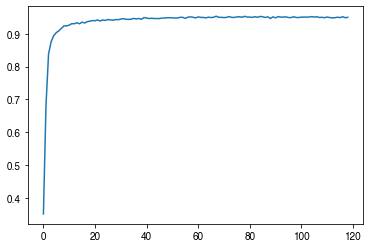

In [13]:
plt.plot(clf.grid_scores_)

In [14]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

201 features selected by RFECV


## Testing

In [15]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished


In [16]:
balanced_accuracy_score(test_label, pred_label)

0.9514430669120502

## Confusion matrix

In [17]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 8)]

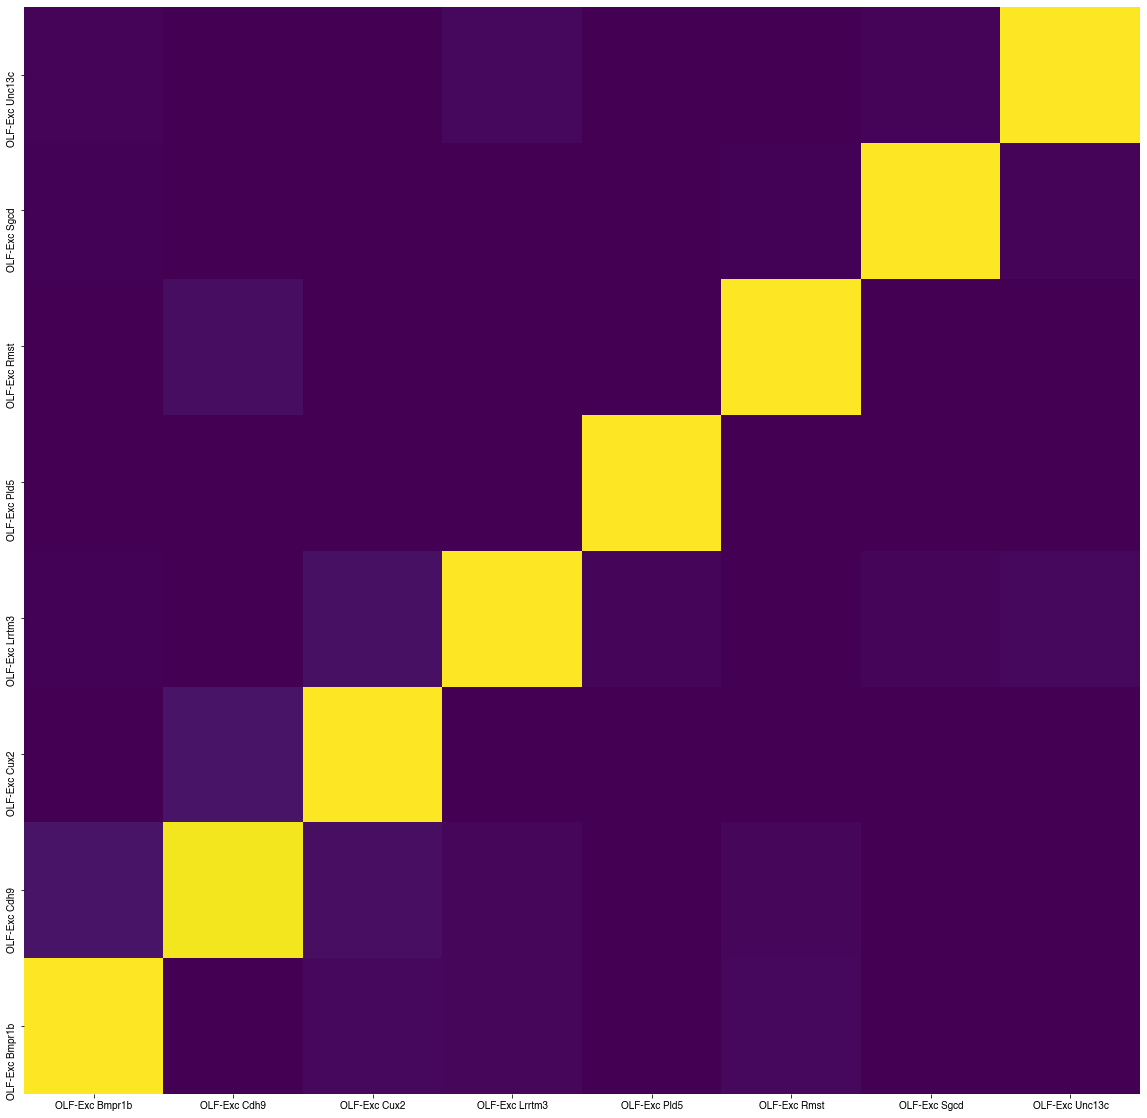

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [19]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

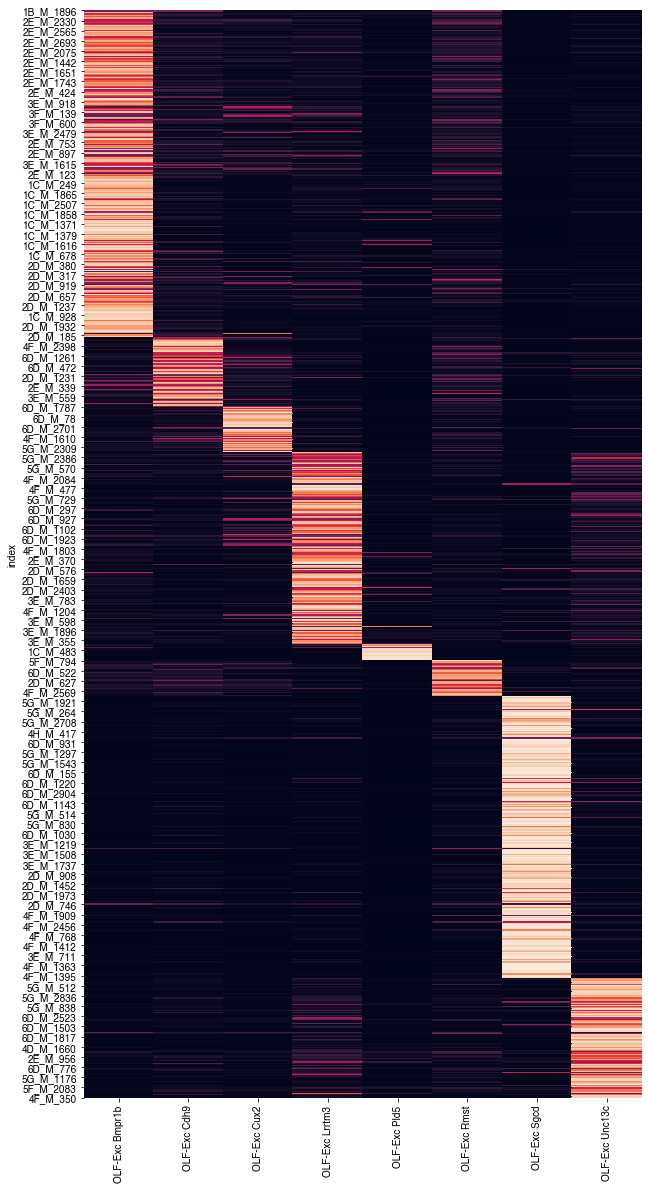

In [20]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

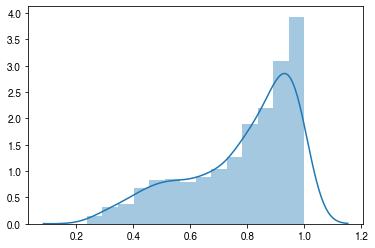

In [21]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [22]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [23]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=n_jobs,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [24]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 5 of 500
building tree 8 of 500
building tree 2 of 500
building tree 4 of 500
building tree 6 of 500
building tree 1 of 500
building tree 11 of 500
building tree 7 of 500
building tree 15 of 500
building tree 3 of 500
building tree 25 of 500
building tree 14 of 500
building tree 10 of 500
building tree 12 of 500
building tree 24 of 500
building tree 18 of 500
building tree 16 of 500
building tree 9 of 500
building tree 13 of 500
building tree 26 of 500
building tree 20 of 500
building tree 21 of 500
building tree 19 of 500
building tree 17 of 500
building tree 30 of 500
building tree 28 of 500
building tree 23 of 500
building tree 27 of 500
building tree 22 of 500
building tree 29 of 500
building tree 31 of 500
building tree 32 of 500
building tree 36 of 500building tree 43 of 500
building tree 35 of 500

building tree 41 of 500
building tree 38 of 500
building tree 34 of 500building tree 33 of 500
building tree 44 of 500
building tree 39 of 500
building tree 47 of 500

b

building tree 57 of 500
building tree 58 of 500building tree 55 of 500
building tree 54 of 500
building tree 59 of 500

building tree 56 of 500building tree 53 of 500

building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 66 of 500
building tree 69 of 500building tree 70 of 500
building tree 71 of 500
building tree 67 of 500
building tree 63 of 500

building tree 64 of 500building tree 80 of 500

building tree 73 of 500
building tree 77 of 500
building tree 74 of 500building tree 68 of 500
building tree 75 of 500building tree 65 of 500
building tree 72 of 500building tree 76 of 500



building tree 79 of 500
building tree 84 of 500
building tree 83 of 500
building tree 82 of 500
building tree 78 of 500
building tree 85 of 500
building tree 88 of 500
building tree 87 of 500
building tree 81 of 500building tree 89 of 500

building tree 86 of 500
building tree 91 of 500
building tree 90 of 500
building tree 92 of 500


[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.4s


building tree 93 of 500
building tree 94 of 500
building tree 96 of 500
building tree 99 of 500building tree 95 of 500

building tree 98 of 500building tree 101 of 500
building tree 105 of 500
building tree 103 of 500

building tree 102 of 500
building tree 97 of 500
building tree 100 of 500
building tree 104 of 500
building tree 107 of 500
building tree 108 of 500
building tree 106 of 500
building tree 110 of 500
building tree 109 of 500
building tree 113 of 500
building tree 111 of 500
building tree 114 of 500
building tree 112 of 500
building tree 119 of 500
building tree 118 of 500
building tree 117 of 500
building tree 120 of 500
building tree 115 of 500
building tree 116 of 500
building tree 123 of 500building tree 122 of 500

building tree 124 of 500
building tree 121 of 500
building tree 125 of 500
building tree 132 of 500
building tree 129 of 500
building tree 128 of 500building tree 127 of 500

building tree 126 of 500
building tree 131 of 500


building tree 133 of 500building tree 134 of 500

building tree 130 of 500building tree 140 of 500

building tree 139 of 500
building tree 135 of 500
building tree 138 of 500building tree 141 of 500
building tree 136 of 500

building tree 137 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 148 of 500
building tree 146 of 500building tree 149 of 500

building tree 150 of 500
building tree 147 of 500building tree 153 of 500
building tree 151 of 500building tree 145 of 500


building tree 152 of 500
building tree 158 of 500
building tree 156 of 500
building tree 157 of 500building tree 155 of 500

building tree 154 of 500
building tree 161 of 500building tree 159 of 500

building tree 164 of 500
building tree 167 of 500building tree 165 of 500building tree 160 of 500


building tree 162 of 500
building tree 163 of 500
building tree 169 of 500
building tree 173 of 500
building tree 171 of 500
building tree 172 of 500
building tree 170 of 500


building tree 174 of 500
building tree 176 of 500
building tree 178 of 500
building tree 183 of 500building tree 181 of 500

building tree 179 of 500
building tree 182 of 500
building tree 185 of 500
building tree 186 of 500
building tree 184 of 500
building tree 180 of 500
building tree 187 of 500
building tree 189 of 500building tree 188 of 500

building tree 195 of 500
building tree 193 of 500building tree 197 of 500building tree 191 of 500


building tree 192 of 500
building tree 190 of 500
building tree 198 of 500building tree 196 of 500
building tree 199 of 500
building tree 194 of 500

building tree 200 of 500
building tree 202 of 500
building tree 203 of 500
building tree 201 of 500
building tree 204 of 500
building tree 206 of 500
building tree 205 of 500building tree 207 of 500

building tree 210 of 500building tree 208 of 500

building tree 209 of 500building tree 212 of 500



building tree 211 of 500
building tree 213 of 500
building tree 215 of 500
building tree 214 of 500
building tree 221 of 500
building tree 216 of 500building tree 222 of 500

building tree 219 of 500
building tree 217 of 500building tree 227 of 500

building tree 223 of 500
building tree 218 of 500building tree 220 of 500

building tree 226 of 500building tree 228 of 500building tree 229 of 500
building tree 230 of 500


building tree 224 of 500
building tree 225 of 500
building tree 232 of 500
building tree 231 of 500
building tree 235 of 500
building tree 233 of 500
building tree 237 of 500
building tree 234 of 500
building tree 238 of 500
building tree 236 of 500
building tree 240 of 500
building tree 239 of 500
building tree 241 of 500
building tree 244 of 500
building tree 243 of 500
building tree 242 of 500
building tree 246 of 500
building tree 245 of 500
building tree 252 of 500
building tree 249 of 500
building tree 253 of 500
building tree 250 of 500


[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    1.2s


building tree 254 of 500
building tree 251 of 500
building tree 247 of 500building tree 248 of 500

building tree 261 of 500
building tree 256 of 500
building tree 263 of 500
building tree 259 of 500
building tree 257 of 500
building tree 262 of 500building tree 260 of 500
building tree 258 of 500

building tree 265 of 500
building tree 255 of 500
building tree 264 of 500
building tree 267 of 500
building tree 268 of 500building tree 266 of 500

building tree 269 of 500building tree 271 of 500
building tree 273 of 500

building tree 270 of 500
building tree 272 of 500
building tree 275 of 500
building tree 274 of 500
building tree 276 of 500building tree 281 of 500
building tree 280 of 500

building tree 283 of 500
building tree 279 of 500
building tree 285 of 500building tree 277 of 500

building tree 286 of 500
building tree 278 of 500
building tree 282 of 500
building tree 284 of 500
building tree 287 of 500building tree 293 of 500

building tree 289 of 500
building tree 288 of 500


building tree 299 of 500
building tree 300 of 500
building tree 297 of 500
building tree 302 of 500
building tree 303 of 500
building tree 301 of 500
building tree 304 of 500
building tree 305 of 500
building tree 308 of 500building tree 309 of 500

building tree 306 of 500building tree 307 of 500

building tree 313 of 500
building tree 311 of 500
building tree 310 of 500
building tree 312 of 500
building tree 319 of 500building tree 321 of 500
building tree 318 of 500

building tree 316 of 500
building tree 314 of 500
building tree 322 of 500
building tree 317 of 500
building tree 328 of 500building tree 326 of 500

building tree 320 of 500building tree 324 of 500

building tree 323 of 500building tree 327 of 500

building tree 325 of 500
building tree 315 of 500building tree 330 of 500

building tree 329 of 500
building tree 331 of 500
building tree 336 of 500
building tree 332 of 500


building tree 333 of 500
building tree 337 of 500
building tree 334 of 500
building tree 338 of 500
building tree 340 of 500
building tree 341 of 500
building tree 335 of 500
building tree 344 of 500building tree 343 of 500

building tree 339 of 500
building tree 342 of 500
building tree 345 of 500
building tree 346 of 500
building tree 354 of 500
building tree 349 of 500
building tree 355 of 500
building tree 347 of 500building tree 350 of 500

building tree 352 of 500
building tree 348 of 500
building tree 356 of 500
building tree 351 of 500
building tree 353 of 500building tree 359 of 500building tree 361 of 500


building tree 360 of 500
building tree 358 of 500
building tree 357 of 500
building tree 362 of 500
building tree 366 of 500building tree 363 of 500

building tree 364 of 500
building tree 369 of 500building tree 365 of 500

building tree 368 of 500
building tree 372 of 500building tree 371 of 500building tree 367 of 500

building tree 370 of 500

building tree 374 of 500

building tree 378 of 500building tree 377 of 500

building tree 373 of 500
building tree 380 of 500
building tree 376 of 500building tree 381 of 500

building tree 384 of 500
building tree 379 of 500
building tree 382 of 500
building tree 386 of 500
building tree 383 of 500
building tree 385 of 500
building tree 387 of 500
building tree 388 of 500
building tree 390 of 500
building tree 392 of 500building tree 393 of 500
building tree 389 of 500
building tree 391 of 500

building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 399 of 500building tree 403 of 500
building tree 397 of 500building tree 400 of 500


building tree 402 of 500
building tree 401 of 500
building tree 405 of 500
building tree 398 of 500
building tree 404 of 500
building tree 412 of 500building tree 413 of 500

building tree 406 of 500
building tree 408 of 500building tree 407 of 500
building tree 410 of 500

building tree 411 of 500
building tree 409 of 500
building tree 414 of 500


building tree 417 of 500

building tree 420 of 500
building tree 419 of 500building tree 416 of 500
building tree 423 of 500

building tree 418 of 500building tree 422 of 500

building tree 425 of 500building tree 426 of 500

building tree 424 of 500
building tree 421 of 500
building tree 428 of 500building tree 432 of 500

building tree 429 of 500
building tree 427 of 500building tree 431 of 500

building tree 430 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 433 of 500
building tree 439 of 500building tree 437 of 500

building tree 441 of 500
building tree 446 of 500
building tree 442 of 500
building tree 444 of 500
building tree 440 of 500
building tree 445 of 500building tree 438 of 500

building tree 443 of 500
building tree 448 of 500
building tree 447 of 500building tree 449 of 500

building tree 451 of 500building tree 452 of 500

building tree 456 of 500
building tree 450 of 500
building tree 454 of 500
building tree 457 of 500

building tree 459 of 500
building tree 453 of 500
building tree 464 of 500building tree 462 of 500
building tree 463 of 500building tree 455 of 500


building tree 460 of 500
building tree 458 of 500
building tree 466 of 500
building tree 461 of 500
building tree 465 of 500
building tree 468 of 500
building tree 467 of 500
building tree 469 of 500
building tree 471 of 500building tree 472 of 500

building tree 473 of 500
building tree 470 of 500building tree 474 of 500

building tree 477 of 500building tree 475 of 500

building tree 478 of 500
building tree 479 of 500building tree 480 of 500

building tree 482 of 500building tree 481 of 500

building tree 484 of 500
building tree 476 of 500
building tree 485 of 500
building tree 483 of 500
building tree 491 of 500
building tree 486 of 500
building tree 490 of 500
building tree 487 of 500
building tree 489 of 500
building tree 495 of 500
building tree 492 of 500building tree 488 of 500
building tree 494 of 500

building tree 497 of 500


[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    2.6s finished


['Model/FinalClassifier.lib']

## Final Pred

In [25]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished


In [26]:
balanced_accuracy_score(test_label, final_pred_label)

0.9503349164211997

## Final evaluate

In [27]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 8)]

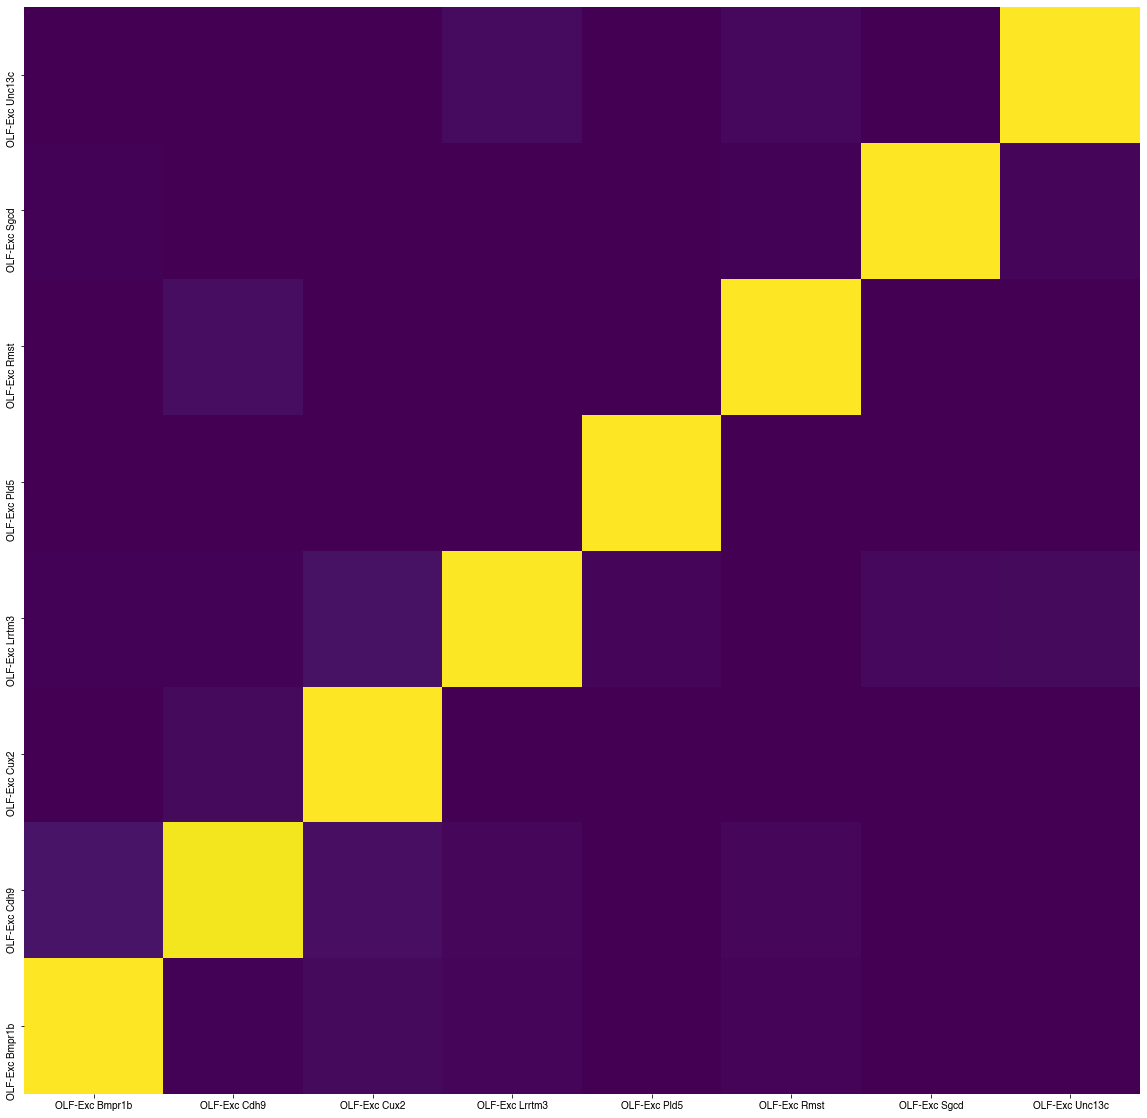

In [28]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [29]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

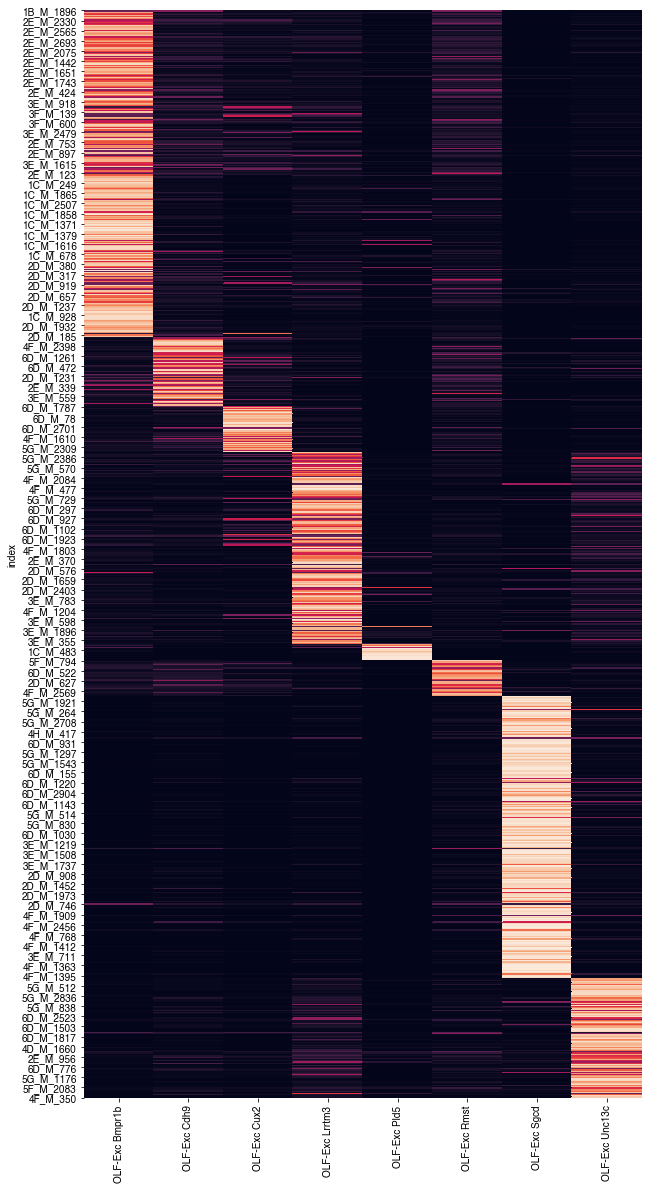

In [30]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

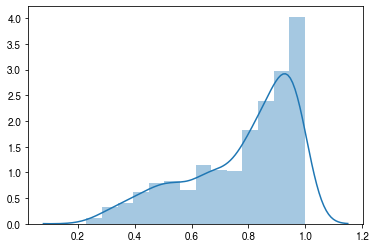

In [31]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [32]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')